## Project: Toxic Comment Filter

The present project aims to develop a Deep Learning multi-label classification model for filtering toxic comments within social network platforms.<br> To achieve this goal, the project is divided into several distinct steps:

* **Data Exploration**: In this phase, we will delve into the dataset to gain a better understanding of the data;
* **Data Pre-processing**: The collected dataset will undergo a comprehensive data cleaning and pre-processing pipeline. This includes tasks such as text tokenization to transform the raw data into a format suitable for training Deep Learning models;
* **Model Building**: The next step is to train a Deep Learning model on the preprocessed text data, capable of multi-label classification;
* **Model Evaluation and Prediction**: In the final phase, we will assess the performance of the trained models using appropriate evaluation metrics. The goal is to select the best-performing model based on these metrics, showcasing its ability to detect and filter toxic comments effectively.

The difference between *multi-class* and *multi-label* classification is that in multi-class problems the classes are mutually exclusive, whereas for multi-label problems each label represents a different classification task. We will see how to handle this in the Model Building section. However, let's begin with a bit of Data Exploration.

## 1. Data Exploration

First of all, let's import the dataset:

In [1]:
import pandas as pd

BASE_URL = "https://s3.eu-west-3.amazonaws.com/profession.ai/datasets/"
df = pd.read_csv(BASE_URL+"Filter_Toxic_Comments_dataset.csv")
df.shape

(159571, 8)

In [2]:
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0


This dataset consists of 159571 comments, each categorized into one or more of six toxicity categories: `toxic`, `severe_toxic`, `obscene`, `threat`, `insult`, and `identity_hate`. Additionally, it includes a derived variable named `sum_injurious`, calculated by summing the values of the category variables. From the latter variable, it is possible to define the `clean` variable to see how many comments are non-toxic:

In [3]:
df.insert(df.columns.get_loc("sum_injurious"),
          "clean",
          df["sum_injurious"].apply(lambda x: 1 if x==0 else 0))
df.head()

,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,clean,sum_injurious
0,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,1,0
1,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,1,0
2,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,1,0
3,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,1,0
4,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,1,0


Toxic comment classification is a multi-label text classification problem with a highly imbalanced dataset. This can be clearly seen by the following barplot, that shows the number of comments in each category:

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\gugli\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


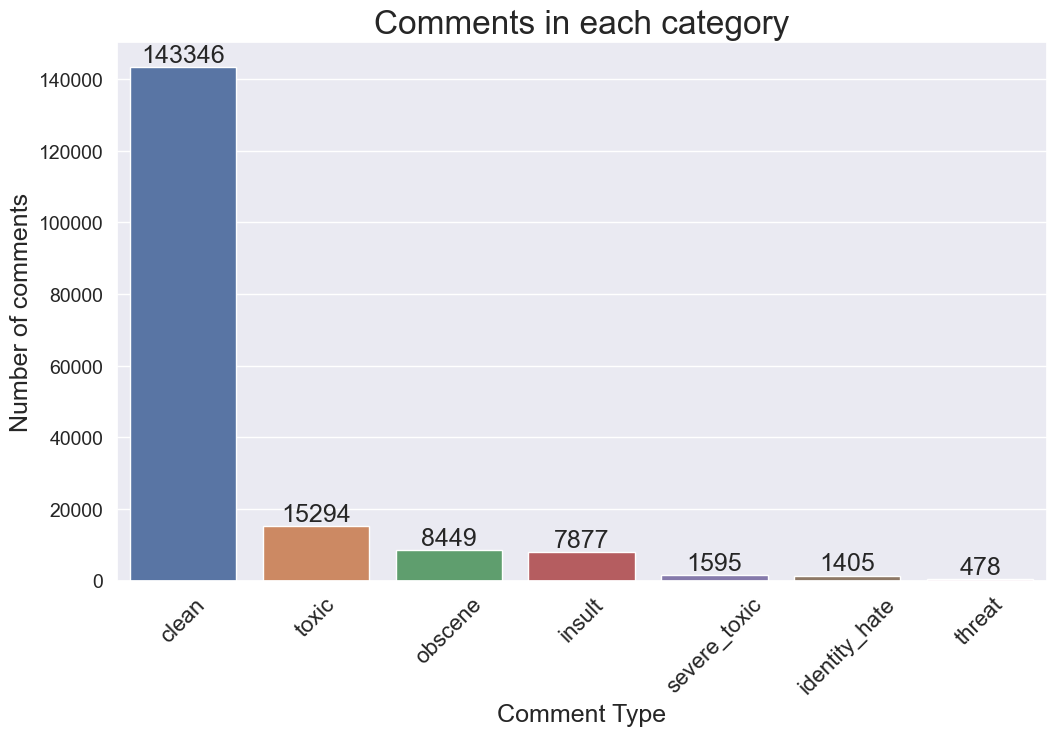

In [4]:
import warnings
from utils import *
warnings.simplefilter(action='ignore', category=FutureWarning)

categories = df.iloc[:,1:-1].sum().sort_values(ascending=False).index
counts = df.iloc[:,1:-1].sum().sort_values(ascending=False).values
show_barplot(categories,counts,"Comments in each category", "Comment Type", "Number of comments")

Furthermore, the following bar plot illustrates the distribution of comments based on the number of labels they have:

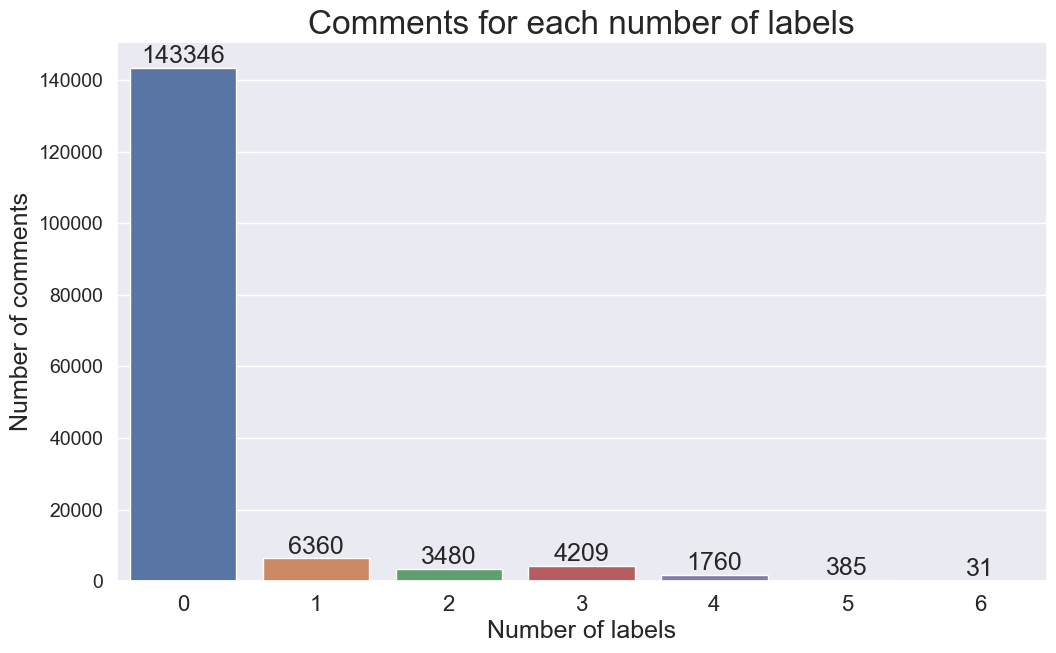

In [5]:
categories = df["sum_injurious"].value_counts().index
counts = df["sum_injurious"].value_counts().values
show_barplot(categories,counts,"Comments for each number of labels", "Number of labels", "Number of comments", xtickrotation=False)

Here's the information conveyed by the two bar plots:
* The dataset exhibits a significant imbalance, with the majority of comments being clean (143,346), while, for instance, there are only 478 comments labeled as "threat". This should be taken into account during the training of the Deep Learning model.
* There is a decreasing trend in the number of comments as the number of labels increases, with only 31 comments having all six labels.

## 1. Pre-processing

Now, let's move on to the data preprocessing phase. To clean data before performing tokenization, a custom function is created, called `text_preprocessing`, that applies the following steps to the comments:
* **Lowercasing**: The first step is to convert the entire text to lowercase using the `lower()` method. This is done to ensure that all words are in the same case, making it easier for subsequent processing steps and analysis.
* **Regular Expression Cleaning**: A regular expression (regex) is used to remove specific patterns from the text, in particular words containing only one letter or one letter followed or preceded by one or more punctuation characters, tabs, or line breaks.
* **Stopword Removal**: Common English stopwords are removed from the text. Stopwords are words that are frequently used in language but often do not carry significant meaning (e.g., "the", "and", "is"). The stopwords are defined in the `nltk` library. The reason why stop words are critical to many applications is that, if we remove the words that are very commonly used in a given language, we can focus on the important words instead.
* **Stemming**: Finally, stemming is applied to the remaining words in the text. Stemming reduces words to their root or base form. The Snowball Stemmer for English is used to perform stemming.

In [6]:
preprocessed_df = text_preprocessing(df)

To avoid having to process the comments every time, it is decided to save the preprocessed DataFrame to a Parquet file:

In [7]:
preprocessed_df.to_parquet("preprocessed_data.parquet", index=False)

Once this is done, the content of this file can be loaded by simply using the `read_parquet` function:

In [8]:
preprocessed_df = pd.read_parquet("preprocessed_data.parquet")

The next step is to split the dataset in train, validation and test set. This is done with the `train_test_val_split` function:

In [9]:
X = preprocessed_df["comment_text"].values
y = preprocessed_df.drop(["comment_text","sum_injurious", "clean"], axis=1).values

In [102]:
X_train, X_val, X_test, y_train, y_val, y_test = \
    train_test_val_split(X, y, 0.8, 0.2, random_state=0)

In [11]:
X_train.shape, X_test.shape, X_val.shape

((95742,), (31915,), (31914,))

In [12]:
y_train.shape, y_test.shape, y_val.shape

((95742, 6), (31915, 6), (31914, 6))

Finally, the preprocessed comments are converted into sequences, by means of the `Tokenizer` class and the `pad_sequences` function, to pad the sequences to all have the same length. This is achieved by the custom function `get_sequences`:

In [103]:
padded_train_sequences, padded_val_sequences, padded_test_sequences, vocab_size, maxlen = \
    get_sequences(X_train, X_val, X_test)

In [104]:
padded_train_sequences.shape, padded_val_sequences.shape, padded_test_sequences.shape

((95742, 1250), (31914, 1250), (31915, 1250))

In addition to the three sets of sequences, the function returns the `vocab_size` and `maxlen` variables:
* `vocab_size` is the size of the vocabulary, i.e. maximum integer index + 1, as defined by the documentation of the `Embedding` layer that we will use in the following section. It coincides with `num_words`, namely the maximum number of words to keep based on word frequency that needs to be specified during tokenization. Its default value in `get_sequences` is 1000.
* `maxlen` is the maximum length of train sequences, to which all the sequences are padded.

In [105]:
vocab_size, maxlen

(1000, 1250)

## 2. Model Building

In [82]:
warnings.simplefilter(action='ignore', category=UserWarning)
import numpy as np
import pickle
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import (
    Embedding,
    Conv1D,
    MaxPooling1D,
    LSTM,
    GRU,
    Dense,
    Dropout,
    Bidirectional,
    SimpleRNN,
    BatchNormalization
)
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow_addons.metrics import HammingLoss
from tensorflow.keras.models import load_model

Since in multilabel classification more than one labels can be the correct output for each input sample, it is decided to use **Hamming Loss** (HL) as metric to evaluate the performance of the model on the validation set. Hamming Loss is defined as the fraction of misclassified labels to the total number of labels. For the binary case:
$$
HL=1-\text{accuracy}
$$
Of course, a lower value of Hamming Loss will indicates a better classifier.

In all the subsequent models, the `EarlyStopping` callback will be used. It provides a safeguard against overfitting by monitoring the validation loss and stopping training if the model's performance on unseen data doesn't improve over a specified number of epochs (defined by the `patience` parameter):

In [17]:
early_stopping = EarlyStopping(monitor='val_loss',
                               patience=5,
                               restore_best_weights=True)

### 2.1 Simple RNN Model

The first model that was built, referred to as `model_RNN`, is constructed as follows:

In [18]:
model_RNN = Sequential()
model_RNN.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_RNN.add(Dropout(0.8))
model_RNN.add(SimpleRNN(64, activation='tanh'))
model_RNN.add(Dropout(0.5))
model_RNN.add(Dense(6,activation='sigmoid'))
model_RNN.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1250, 128)         128000    
                                                                 
 dropout (Dropout)           (None, 1250, 128)         0         
                                                                 
 simple_rnn (SimpleRNN)      (None, 64)                12352     
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense (Dense)               (None, 6)                 390       
                                                                 
Total params: 140742 (549.77 KB)
Trainable params: 140742 (549.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


It is decided to include two **dropout** layers after the embedding layer and before the output layer, since they help prevent **overfitting**, which occurs when a model learns to perform well on the training data but doesn't generalize effectively to new, unseen data.<br> Dropout reduces the likelihood of neurons co-adapting or relying on specific features during training. When dropout is applied, different sets of neurons are active in each forward and backward pass, forcing the network to learn more robust features that work in different combinations. This can lead to a more resilient model that performs better on unseen data.

Let's compile the model, using `binary_crossentropy` as loss function, i.e. without taking into account class imbalance:

In [19]:
model_RNN.compile(loss='binary_crossentropy',
                   optimizer='rmsprop',
                   metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [20]:
hist_RNN = model_RNN.fit(padded_train_sequences, y_train,
                         validation_data=(padded_val_sequences, y_val),
                         epochs=10, callbacks=[early_stopping],
                         batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 516s 344ms/step - loss: 0.1544 - hamming_loss: 0.0518 - val_loss: 0.0865 - val_hamming_loss: 0.0246
Epoch 2/10
1496/1496 [==============================] - 533s 357ms/step - loss: 0.0867 - hamming_loss: 0.0261 - val_loss: 0.0738 - val_hamming_loss: 0.0238
Epoch 3/10
1496/1496 [==============================] - 534s 357ms/step - loss: 0.0828 - hamming_loss: 0.0250 - val_loss: 0.0720 - val_hamming_loss: 0.0224
Epoch 4/10
1496/1496 [==============================] - 544s 364ms/step - loss: 0.0788 - hamming_loss: 0.0236 - val_loss: 0.0743 - val_hamming_loss: 0.0217
Epoch 5/10
1496/1496 [==============================] - 549s 367ms/step - loss: 0.0803 - hamming_loss: 0.0252 - val_loss: 0.0721 - val_hamming_loss: 0.0218
Epoch 6/10
1496/1496 [==============================] - 549s 367ms/step - loss: 0.0774 - hamming_loss: 0.0237 - val_loss: 0.0719 - val_hamming_loss: 0.0215
Epoch 7/10
1496/1496 [==============================] - 547s 366

As for the preprocessed comments, it is decided to save both the model and the history:

In [21]:
model_RNN.save("models/rnn_model.keras")
pickle.dump(hist_RNN, open('histories/rnn_history.pkl','wb'))

In [22]:
rnn_model = load_model("models/rnn_model.keras")
rnn_history = pickle.load(open('histories/rnn_history.pkl','rb'))

Let's plot the learning curves of the loss function and the Hamming Loss:

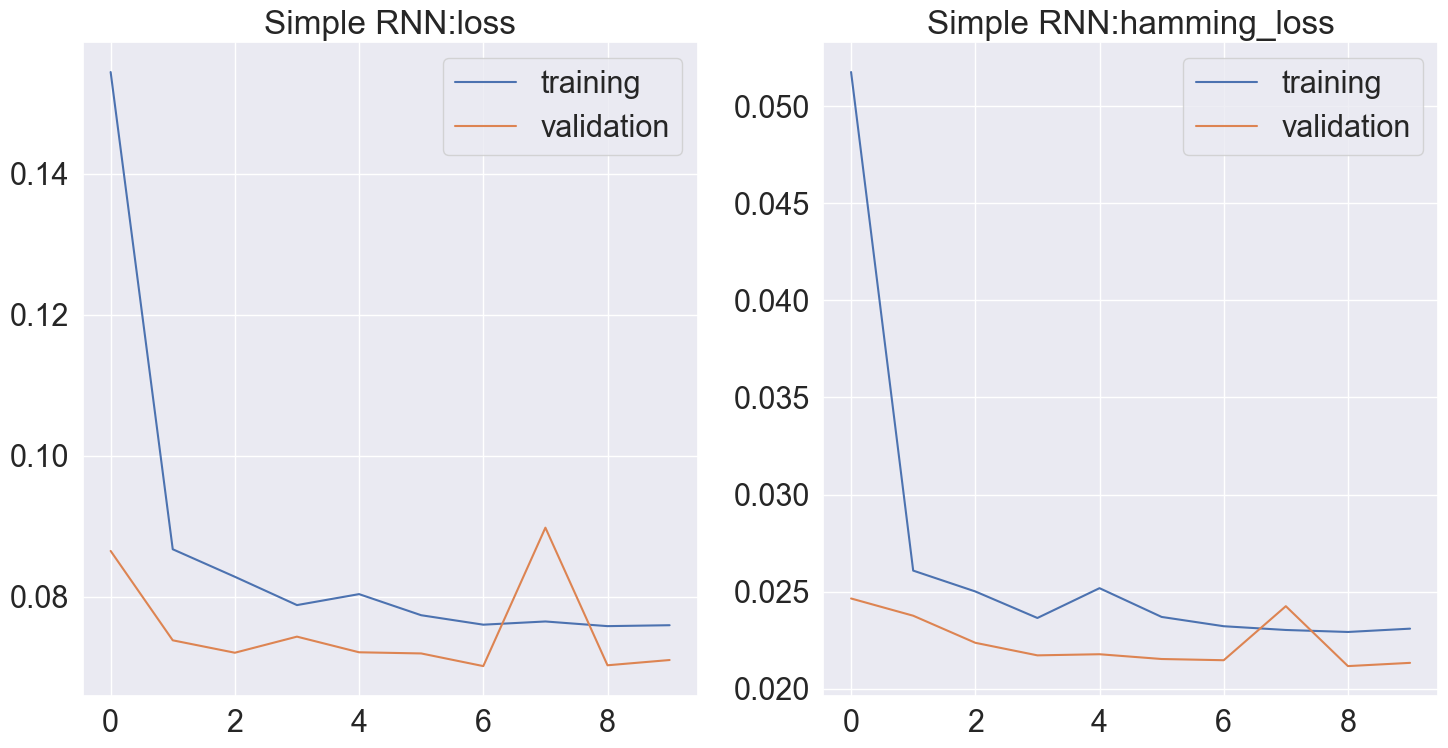

In [23]:
plot_learning_curves(rnn_history, 'Simple RNN')

In addition, the following plot shows the multilabel confusion matrices, one for each label:

998/998 [==============================] - 41s 41ms/step


C:\Users\gugli\Desktop\git\toxic_comment_filter\utils.py:183: RuntimeWarning: invalid value encountered in scalar divide
  precision = tp / (tp + fp)


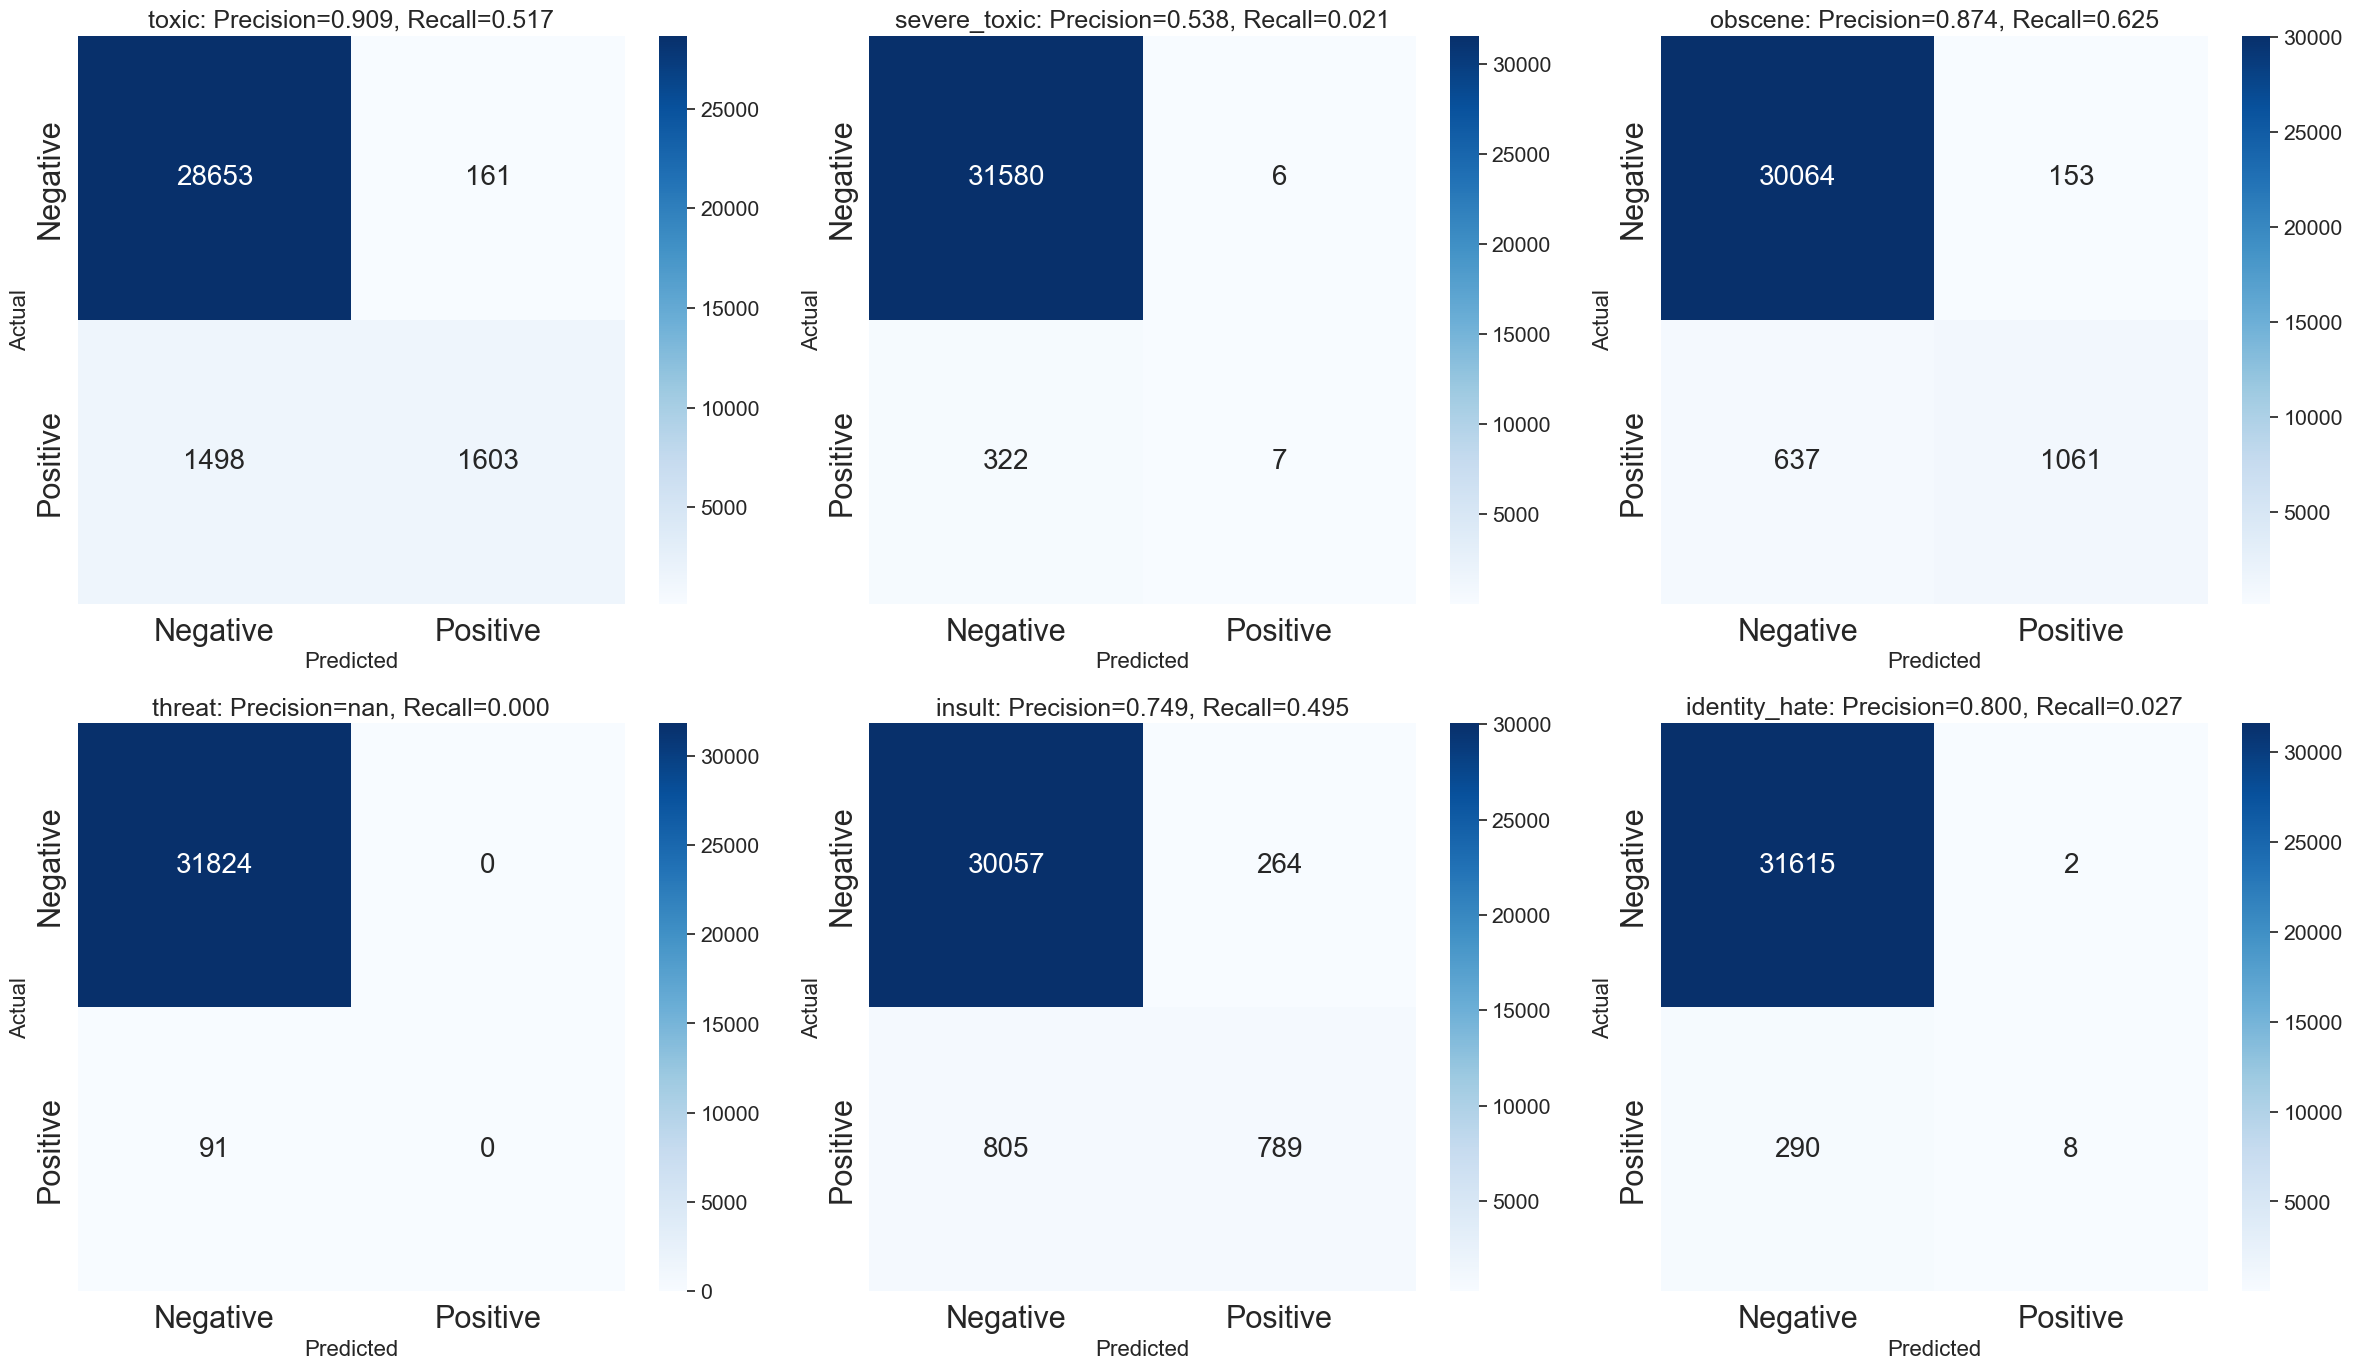

In [24]:
labels = ["toxic", "severe_toxic", "obscene", "threat", "insult", "identity_hate"]
plot_mcms(rnn_model, padded_test_sequences, y_test, labels=labels)

In [108]:
y_pred_proba = rnn_model.predict(padded_test_sequences)

998/998 [==============================] - 42s 42ms/step


In [112]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "Label": labels,
    "rnn_precision": precisions,
    "rnn_recall": recalls
}

df = pd.DataFrame(data)
df

C:\Users\gugli\AppData\Local\Temp\ipykernel_25744\3344892529.py:7: RuntimeWarning: invalid value encountered in scalar divide
  precision = round(tp / (tp + fp),3)


,Label,rnn_precision,rnn_recall
0,toxic,0.909,0.517
1,severe_toxic,0.538,0.021
2,obscene,0.874,0.625
3,threat,NaN,0.000
4,insult,0.749,0.495
5,identity_hate,0.800,0.027


It is concluded that the amount of true positives for each label is very low, especially for `threat`, `identity_hate` and `severe_toxic`, leading to low values of both precision and recall. As a first step to improve the performance of the model, it is decided to change the loss function.

#### Changing the Loss Function

To deal with the class imbalance problem, that leads to very bad values of both precision and recall in the previous model, it is decided to build a custom loss function, namely a **weighted binary cross entropy**, to give more importance to less represented labels while computing the loss function. It is given by: 
$$
-\frac{1}{NM}\sum_{i=1}^N\sum_{j=1}^M\left[w_{1,j}y_{ij}\log(p_{ij})+w_{0,j}(1-y_{ij})\log(1-p_{ij})\right]
$$
where:
* $N$ is the number of instances,
* $M$ is the number of classes,
* $y_{ij}$ is the true label of instance $i$ for class $j$,
* $p_{ij}$ is the predicted probability of instance $i$ for class $j$,
* $w_{0,j}$ ($w_{1,j}$) is the vector of the weights for the $0$ ($1$) values of each label.

Therefore, let's define the class weights and the function to compute the weighted binary cross entropy:

In [25]:
num_obs_per_label = np.sum(y_train, axis=0)
n_samples = len(padded_train_sequences)
weights = len(padded_train_sequences) / num_obs_per_label
class_weights_0 = []
class_weights_1 = []

for i in num_obs_per_label:
    weight_0 = n_samples / (n_samples - i)
    weight_1 = n_samples / i
    total = weight_0 + weight_1
    weight_0 /= total
    weight_1 /= total
    class_weights_0.append(weight_0)
    class_weights_1.append(weight_1)
    
total_sum = sum(class_weights_0)+sum(class_weights_1)
class_weights_0 = [weight/total_sum for weight in class_weights_0]
class_weights_1 = [weight/total_sum for weight in class_weights_1]
class_weights = []
class_weights.append(class_weights_0)
class_weights.append(class_weights_1)
class_weights

[[0.01599959613683998,
  0.0016433052718068698,
  0.008862359257170311,
  0.0005204960553710318,
  0.00824786056972558,
  0.0014396329023138572],
 [0.15066707052982667,
  0.1650233613948598,
  0.15780430740949636,
  0.16614617061129563,
  0.15841880609694106,
  0.1652270337643528]]

In [26]:
@keras.saving.register_keras_serializable()
def get_weighted_binary_crossentropy(class_weights):
    """
    Create a custom weighted binary cross-entropy loss function.
    This function returns a weighted binary cross-entropy loss function
    that can be used as a loss metric in deep learning models. The
    binary cross-entropy loss is modified to give different weights to
    the two binary classes based on the `class_weights` parameter.

    Parameters:
    class_weights (list or tuple): A list of two lists representing
        the weights for class 0 (negative class) and class 1
        (positive class), respectively.

    Returns:
    function: A callable weighted binary cross-entropy loss function
        that takes two arguments: `y_true` (ground truth binary labels) and
        `y_pred` (predicted binary probabilities), and computes the weighted
        binary cross-entropy loss.
    """
    def weighted_binary_crossentropy(y_true, y_pred):
        """
        Calculate the weighted binary cross-entropy for a multi-label classification problem.

        Parameters:
        y_true: Tensor of actual target values (labels).
        y_pred: Tensor of model predictions.

        Returns:
        tf.Tensor: Value of the weighted binary cross-entropy.
        """
        epsilon = 1e-15
        y_true = tf.cast(y_true, tf.float32)
        y_pred = tf.clip_by_value(y_pred, epsilon, 1 - epsilon)
        weights_0 = tf.constant(class_weights[0], dtype=tf.float32)
        weights_1 = tf.constant(class_weights[1], dtype=tf.float32)
        weighted_bce = - (weights_1 * y_true * tf.math.log(y_pred) + weights_0 * (1 - y_true) * tf.math.log(1 - y_pred))
        mean_weighted_bce = tf.reduce_mean(weighted_bce)
        return mean_weighted_bce
    return weighted_binary_crossentropy

### 2.2 Weighted Simple RNN Model

Let us consider the same model as before, but with the weighted binary cross entropy as loss function:

In [27]:
model_RNN_weighted = Sequential([
    Embedding(input_dim=vocab_size,
              output_dim=128,
              input_length=maxlen),
    Dropout(0.8),
    SimpleRNN(64, activation='tanh'),
    Dropout(0.5),
    Dense(6,activation='sigmoid')
])
model_RNN_weighted.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_2 (Dropout)         (None, 1250, 128)         0         
                                                                 
 simple_rnn_1 (SimpleRNN)    (None, 64)                12352     
                                                                 
 dropout_3 (Dropout)         (None, 64)                0         
                                                                 
 dense_1 (Dense)             (None, 6)                 390       
                                                                 
Total params: 140742 (549.77 KB)
Trainable params: 140742 (549.77 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [28]:
model_RNN_weighted.compile(loss=get_weighted_binary_crossentropy(class_weights),
                           optimizer='rmsprop',
                           metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [29]:
hist_RNN_weighted = model_RNN_weighted.fit(padded_train_sequences, y_train,
                                           validation_data=(padded_val_sequences, y_val),
                                           epochs=10, callbacks=[early_stopping],
                                           batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 514s 343ms/step - loss: 0.0065 - hamming_loss: 0.3504 - val_loss: 0.0043 - val_hamming_loss: 0.1960
Epoch 2/10
1496/1496 [==============================] - 526s 352ms/step - loss: 0.0045 - hamming_loss: 0.1796 - val_loss: 0.0038 - val_hamming_loss: 0.1162
Epoch 3/10
1496/1496 [==============================] - 517s 345ms/step - loss: 0.0041 - hamming_loss: 0.1353 - val_loss: 0.0037 - val_hamming_loss: 0.0993
Epoch 4/10
1496/1496 [==============================] - 515s 344ms/step - loss: 0.0039 - hamming_loss: 0.1248 - val_loss: 0.0036 - val_hamming_loss: 0.0852
Epoch 5/10
1496/1496 [==============================] - 517s 346ms/step - loss: 0.0039 - hamming_loss: 0.1169 - val_loss: 0.0036 - val_hamming_loss: 0.0860
Epoch 6/10
1496/1496 [==============================] - 573s 383ms/step - loss: 0.0038 - hamming_loss: 0.1112 - val_loss: 0.0035 - val_hamming_loss: 0.0915
Epoch 7/10
1496/1496 [==============================] - 600s 401

In [30]:
model_RNN_weighted.save("models/rnn_model_weighted.keras")
pickle.dump(hist_RNN_weighted, open('histories/weighted_rnn_history.pkl','wb'))

In [31]:
weighted_rnn_model = load_model("models/rnn_model_weighted.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights)})
weighted_rnn_history = pickle.load(open('histories/weighted_rnn_history.pkl','rb'))

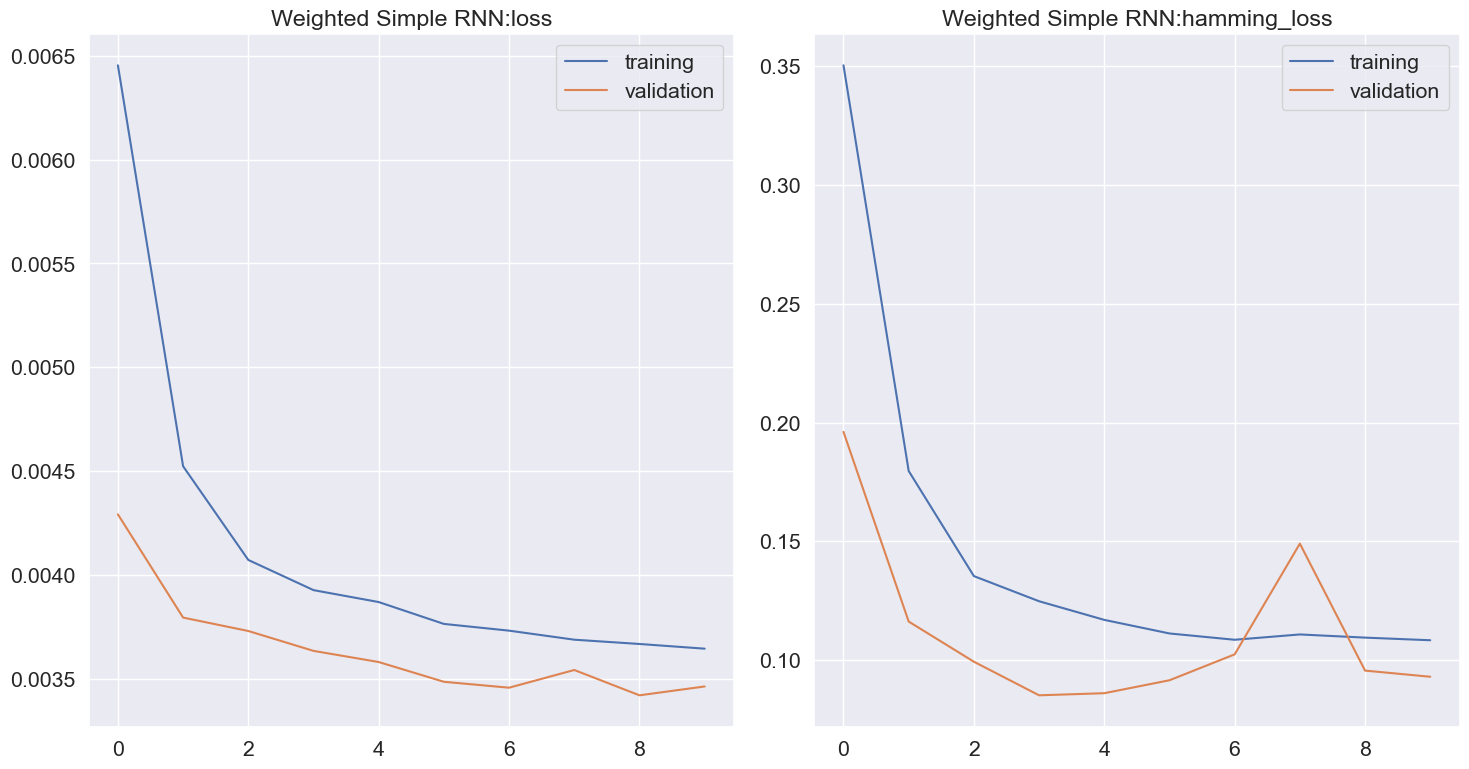

In [32]:
plot_learning_curves(weighted_rnn_history, 'Weighted Simple RNN')

998/998 [==============================] - 40s 40ms/step


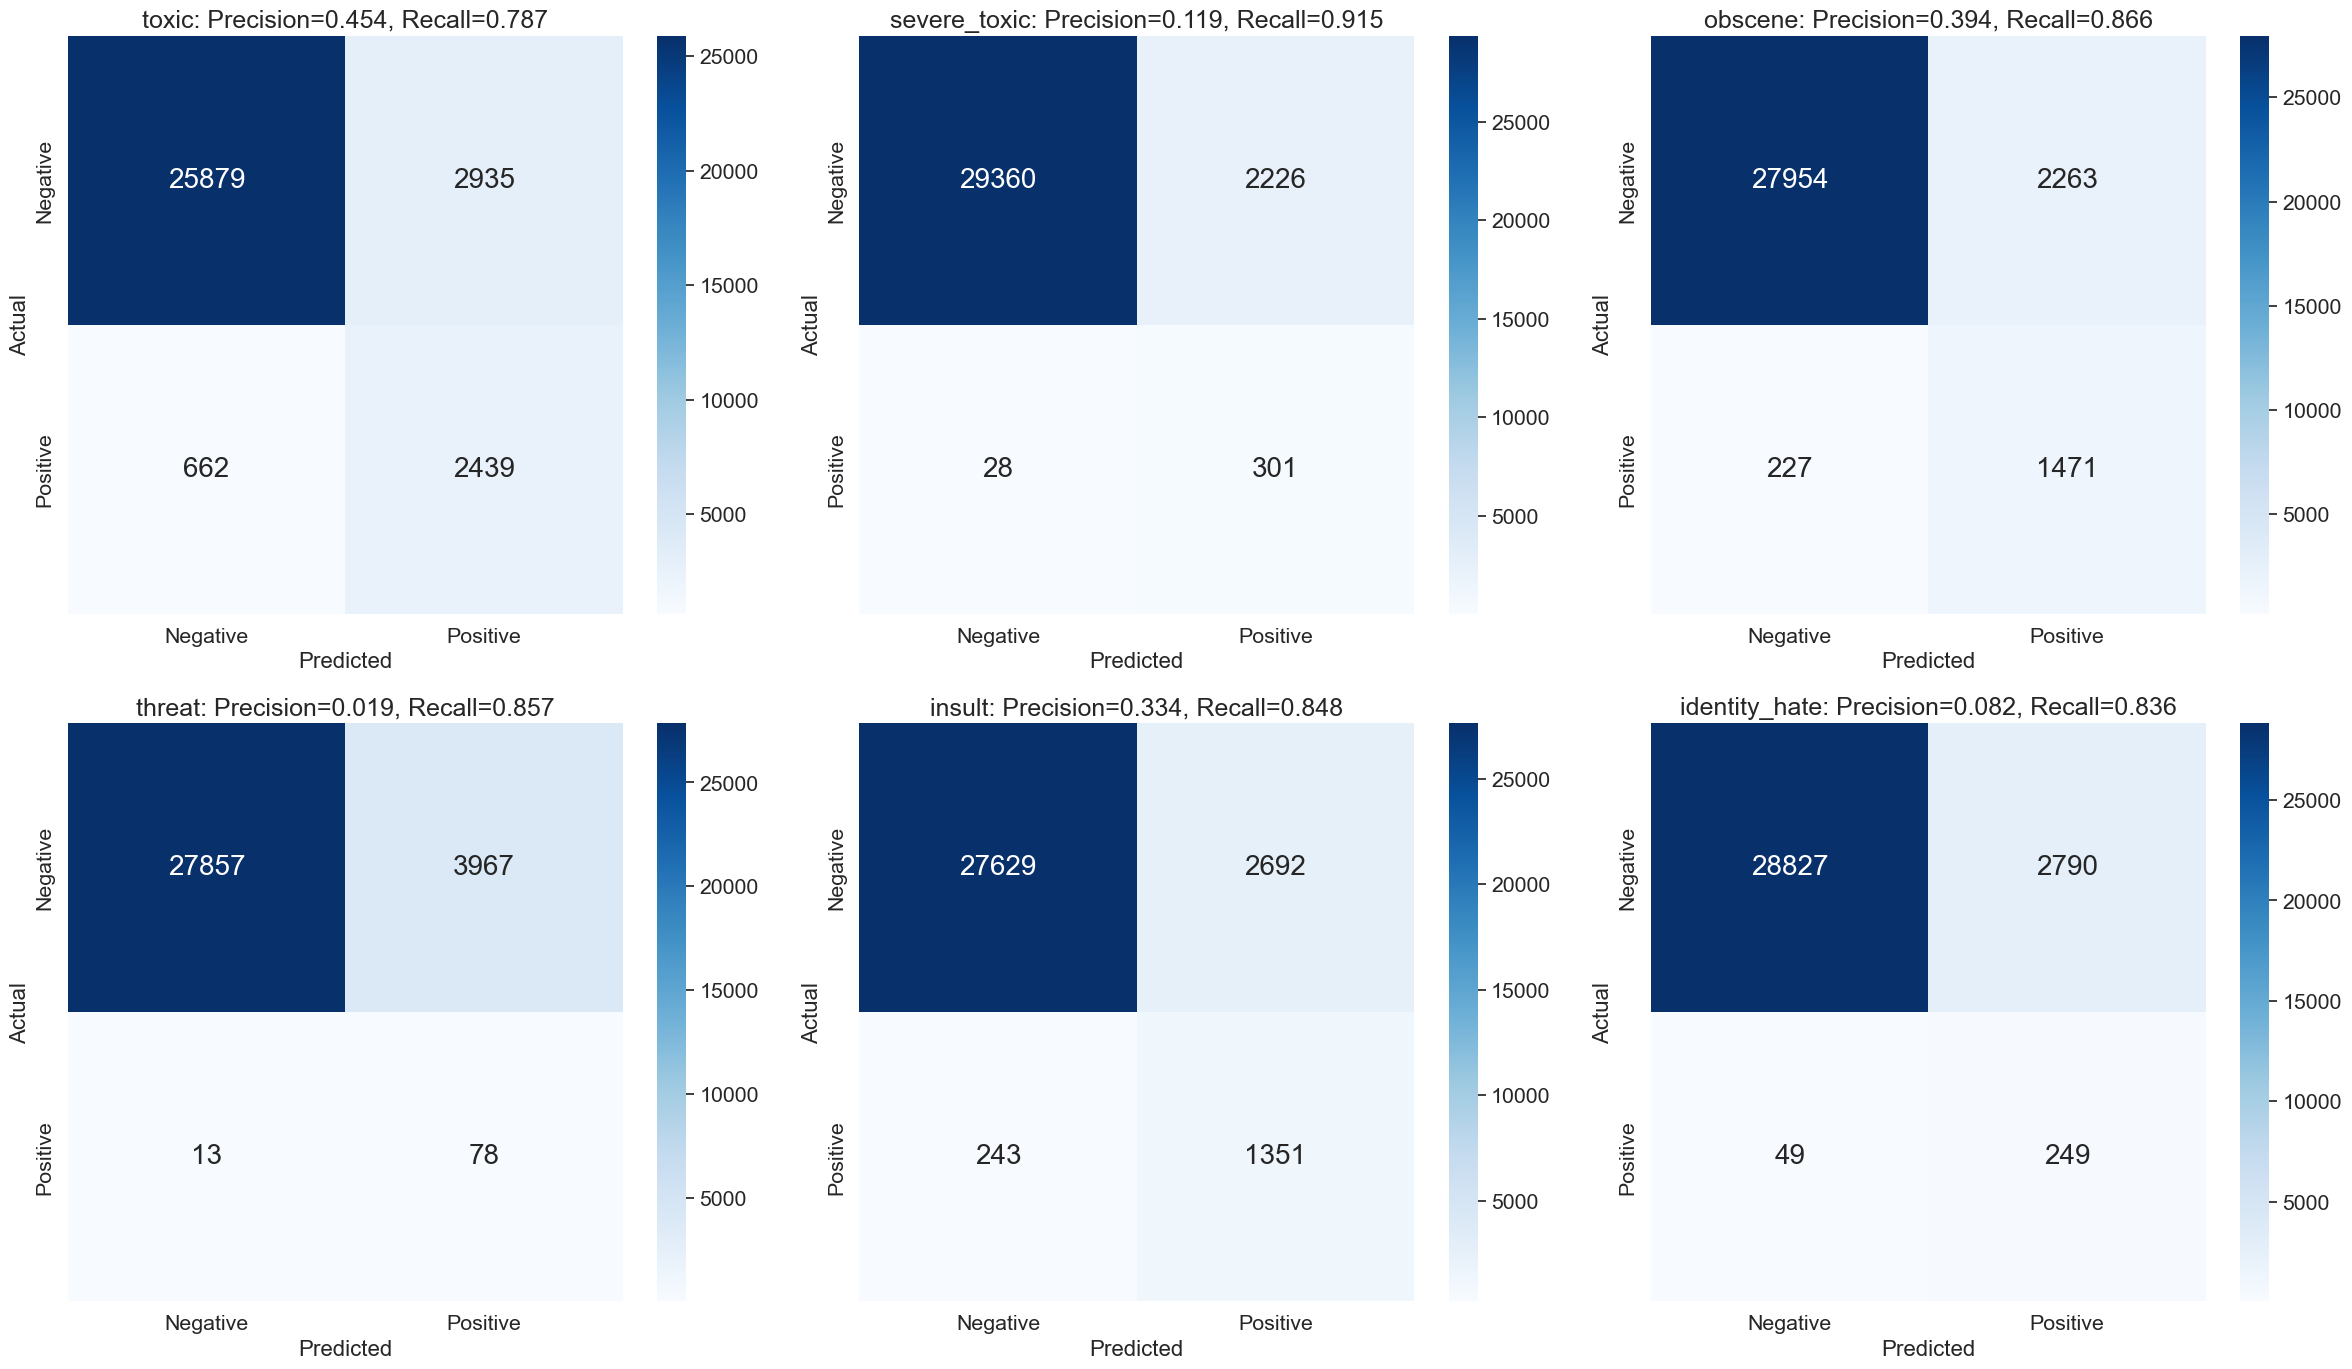

In [33]:
plot_mcms(weighted_rnn_model, padded_test_sequences, y_test, labels=labels)

In [113]:
y_pred_proba = weighted_rnn_model.predict(padded_test_sequences)

998/998 [==============================] - 41s 41ms/step


In [114]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "weighted_rnn_precision": precisions,
    "weighted_rnn_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall
0,toxic,0.909,0.517,0.454,0.787
1,severe_toxic,0.538,0.021,0.119,0.915
2,obscene,0.874,0.625,0.394,0.866
3,threat,NaN,0.000,0.019,0.857
4,insult,0.749,0.495,0.334,0.848
5,identity_hate,0.800,0.027,0.082,0.836


If compared to the previous model, the number of true positives for each label has increased, resulting in higher recall values but lower precision values, because the number of false positives is also increased (as expected). However, these values are still not satisfactory. As a result, different architectures are being considered in the following models, in which the `SimpleRNN` layer is replaced by a `GRU` layer.

### 2.2  Long Short-Term Memory (LSTM) and Gated Recurrent Unit (GRU) Model

LSTM (Long Short-Term Memory) and GRU (Gated Recurrent Unit) are two popular types of recurrent neural network (RNN) architectures.

LSTM is a type of RNN architecture that addresses the vanishing gradient problem associated with traditional RNNs. It was introduced to capture long-range dependencies in sequential data. LSTM cells are designed to store and retrieve information over extended time steps.

The key Features of LSTM are:
* **Memory Cells**: LSTMs have memory cells within each unit that can store and update information over time. These memory cells can capture long-term dependencies in the data.
* **Three Gates**: LSTMs have three types of gates that regulate the flow of information:
    1. **Input Gate**: Controls the flow of new information into the cell.
    2. **Forget Gate**: Controls the removal of information from the cell's memory.
    3. **Output Gate**: Controls the information that gets output from the cell.

GRU is another type of RNN architecture that, like LSTM, addresses the vanishing gradient problem. It simplifies the LSTM architecture by combining the cell state and hidden state, making it computationally more efficient than LSTM.

The key Features of GRU are:
* **Simplified Design**: GRU has a simpler design compared to LSTM, with fewer gates. It combines the cell state and hidden state into a single state vector, reducing the number of parameters.
* **Two Gates**: GRU has two gates:
    * **Reset Gate**: Controls which information from the previous state is forgotten.
    * **Update Gate**: Controls the information to be stored in the current state.
* **Efficient Training**: GRUs are computationally more efficient to train compared to LSTMs, and they often require fewer parameters.

Therefore, the main differencs between the two architectures is their complexity: LSTMs have a more complex architecture with three gates (input, forget, output) and separate cell state and hidden state. In contrast, GRUs have a simpler design with only two gates (reset, update) and a single state vector. For this reason, GRUs are computationally more efficient, which makes them faster to train and more suitable for some applications where computational resources are limited.

Therefore, for computational reasons, it is decided to start from a GRU architecture, building models with LSTM layers only if needed.

### 2.2.1 GRU Model

Let's begin by considering the same model as before, but with the `SimpleRNN` layer replaced by a `GRU` layer (with the same number of units):

In [34]:
model_GRU = Sequential()
model_GRU.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_GRU.add(Dropout(0.8))
model_GRU.add(GRU(64,activation='tanh'))
model_GRU.add(Dropout(0.5))
model_GRU.add(Dense(6,activation='sigmoid'))
model_GRU.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_4 (Dropout)         (None, 1250, 128)         0         
                                                                 
 gru (GRU)                   (None, 64)                37248     
                                                                 
 dropout_5 (Dropout)         (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 6)                 390       
                                                                 
Total params: 165638 (647.02 KB)
Trainable params: 165638 (647.02 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [35]:
model_GRU.compile(loss=get_weighted_binary_crossentropy(class_weights),
                  optimizer='rmsprop',
                  metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [36]:
hist_GRU = model_GRU.fit(padded_train_sequences, y_train,
                         validation_data=(padded_val_sequences, y_val),
                         epochs=10, callbacks=[early_stopping],
                         batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 1097s 733ms/step - loss: 0.0077 - hamming_loss: 0.4288 - val_loss: 0.0072 - val_hamming_loss: 0.3540
Epoch 2/10
1496/1496 [==============================] - 1105s 738ms/step - loss: 0.0060 - hamming_loss: 0.2784 - val_loss: 0.0044 - val_hamming_loss: 0.0743
Epoch 3/10
1496/1496 [==============================] - 1133s 757ms/step - loss: 0.0044 - hamming_loss: 0.1487 - val_loss: 0.0037 - val_hamming_loss: 0.0755
Epoch 4/10
1496/1496 [==============================] - 1110s 742ms/step - loss: 0.0040 - hamming_loss: 0.1150 - val_loss: 0.0037 - val_hamming_loss: 0.0629
Epoch 5/10
1496/1496 [==============================] - 1096s 733ms/step - loss: nan - hamming_loss: 0.0471 - val_loss: nan - val_hamming_loss: 0.0360
Epoch 6/10
1496/1496 [==============================] - 1111s 743ms/step - loss: nan - hamming_loss: 0.0367 - val_loss: nan - val_hamming_loss: 0.0360
Epoch 7/10
1496/1496 [==============================] - 1110s 742ms/st

In [37]:
model_GRU.save("models/gru_model.keras")
pickle.dump(hist_GRU, open('histories/gru_history.pkl','wb'))

In [38]:
gru_model = load_model("models/gru_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights)})
gru_history = pickle.load(open('histories/gru_history.pkl','rb'))

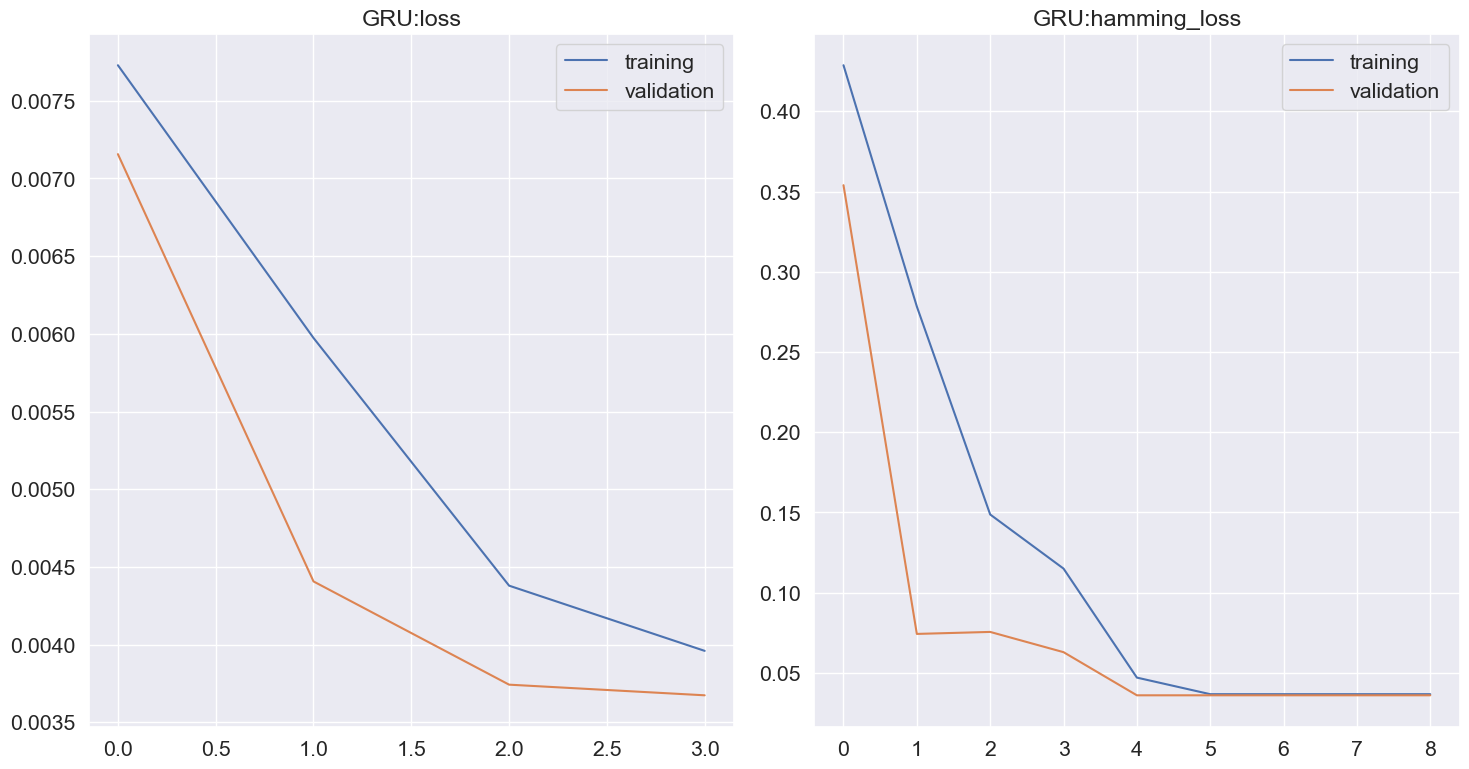

In [39]:
plot_learning_curves(gru_history, 'GRU')

998/998 [==============================] - 80s 79ms/step


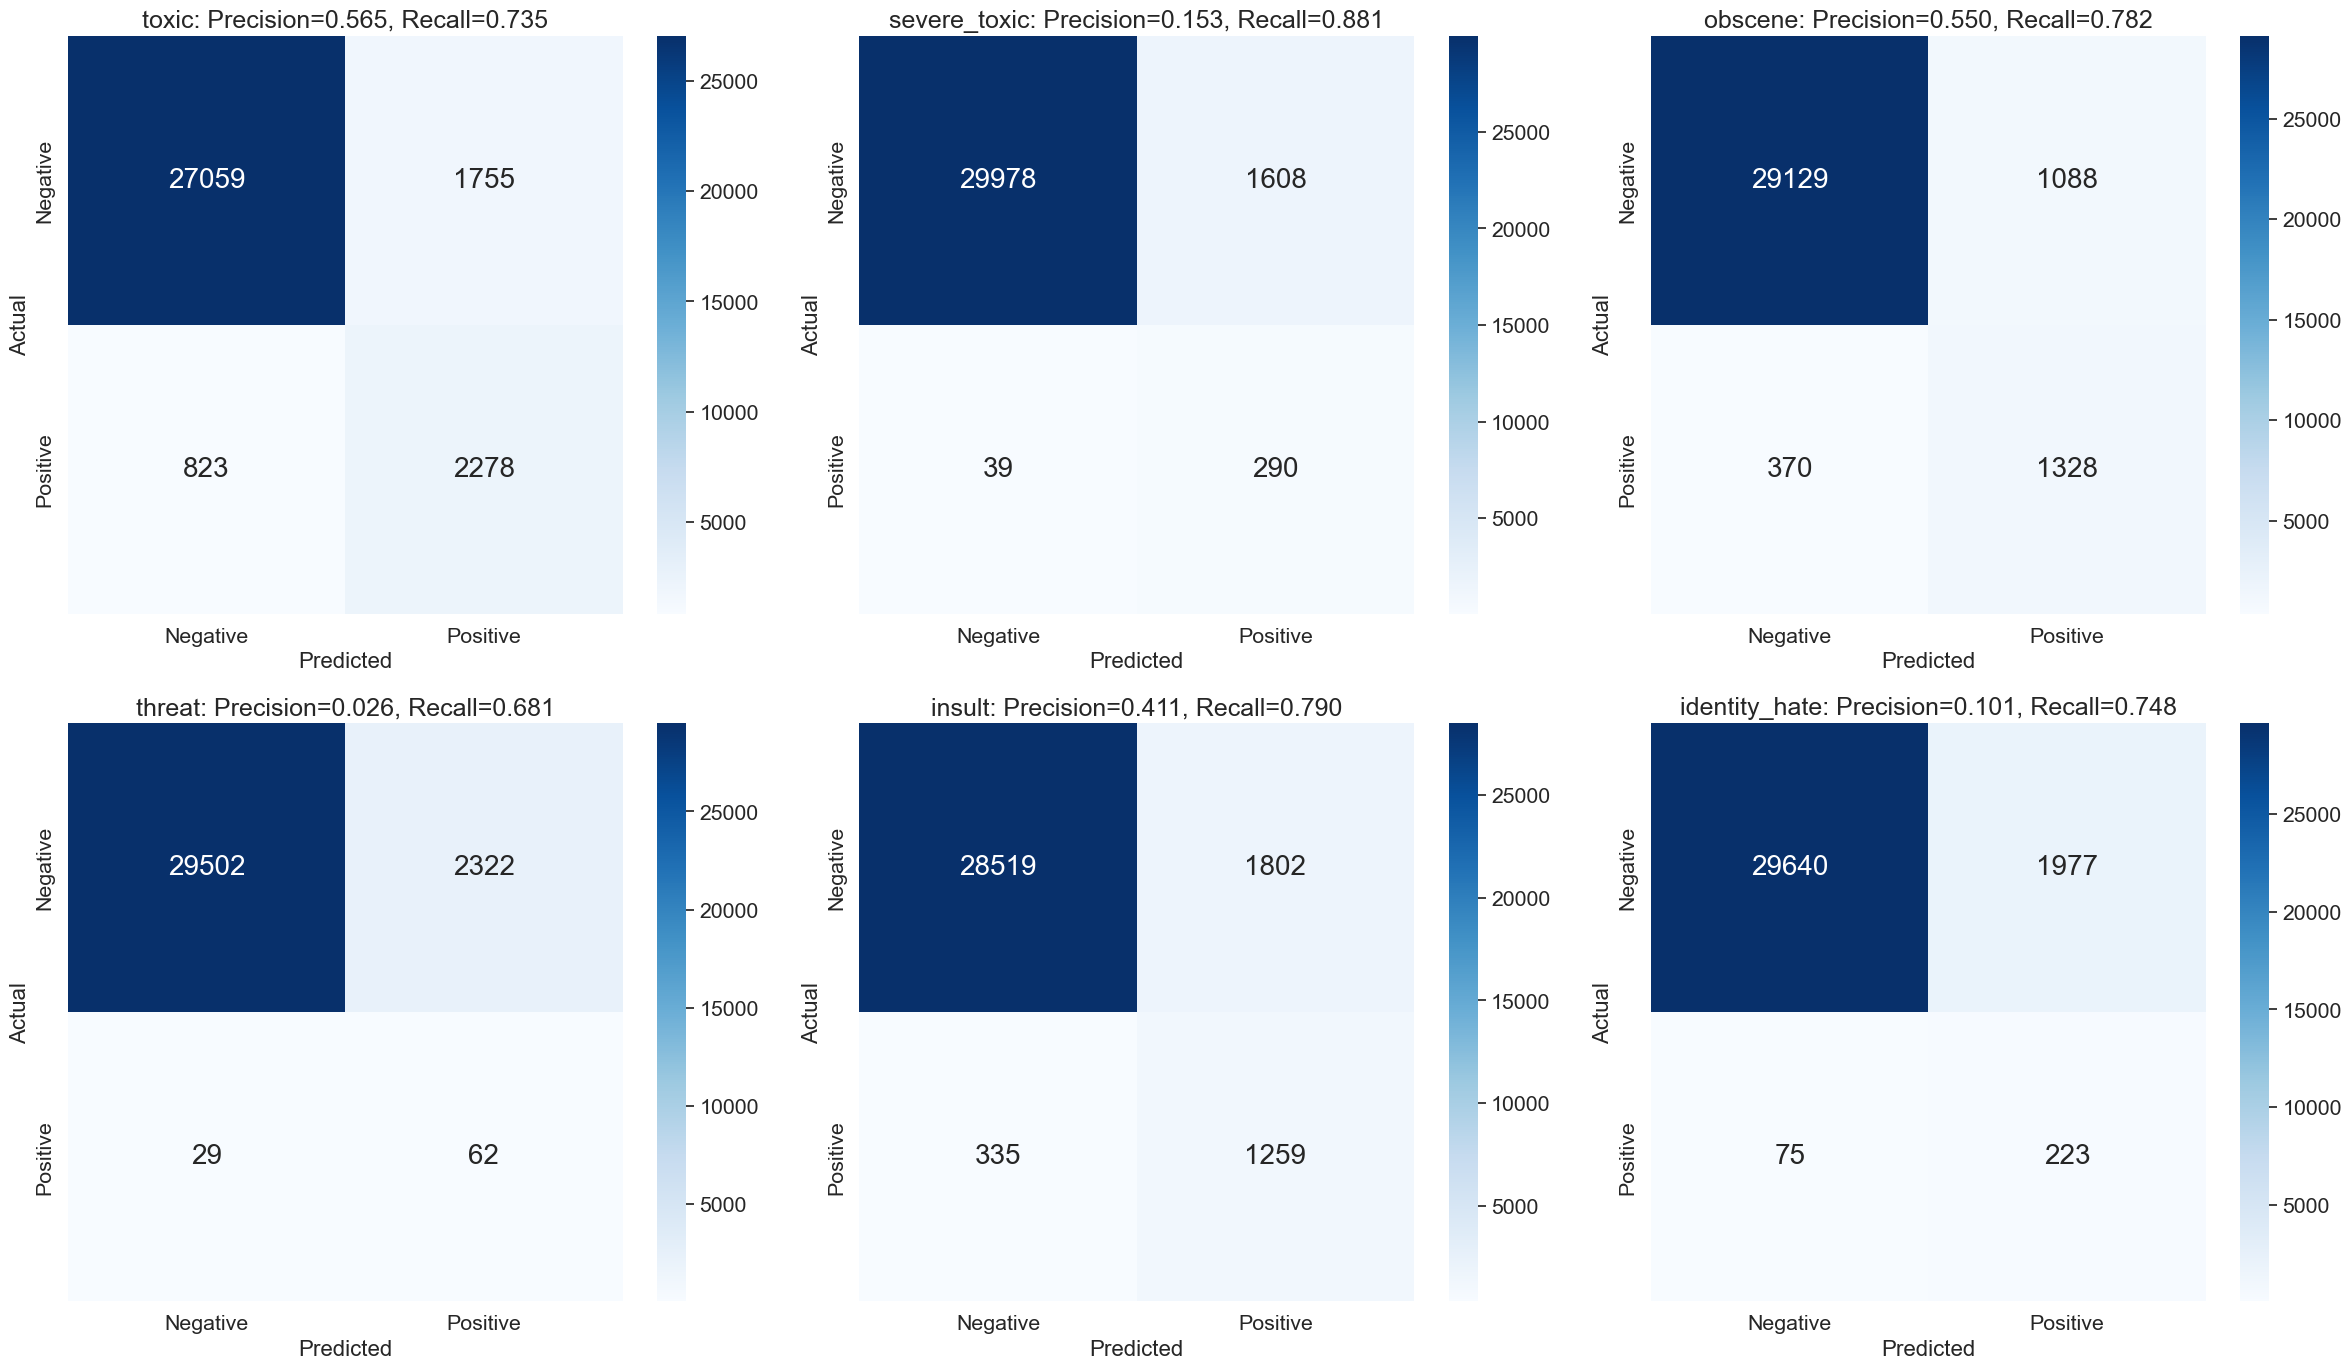

In [40]:
plot_mcms(gru_model, padded_test_sequences, y_test, labels=labels)

In [115]:
y_pred_proba = gru_model.predict(padded_test_sequences)

998/998 [==============================] - 81s 82ms/step


In [116]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "gru_precision": precisions,
    "gru_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall
0,toxic,0.909,0.517,0.454,0.787,0.565,0.735
1,severe_toxic,0.538,0.021,0.119,0.915,0.153,0.881
2,obscene,0.874,0.625,0.394,0.866,0.550,0.782
3,threat,NaN,0.000,0.019,0.857,0.026,0.681
4,insult,0.749,0.495,0.334,0.848,0.411,0.790
5,identity_hate,0.800,0.027,0.082,0.836,0.101,0.748


### 2.2.2 Bidirectional GRU Model

Another variant of the previous model involves considering a bidirectional GRU layer instead of a 'normal' GRU layer. This approach may prove beneficial because a bidirectional GRU can capture dependencies in both the past and future directions of the input sequence, providing a more comprehensive understanding of the data. Let's see if this is the case.

In [41]:
model_bidir_GRU = Sequential()
model_bidir_GRU.add(Embedding(input_dim=vocab_size,
                        output_dim=128,
                        input_length=maxlen))
model_bidir_GRU.add(Dropout(0.8))
model_bidir_GRU.add(Bidirectional(GRU(64,activation='tanh')))
model_bidir_GRU.add(Dropout(0.5))
model_bidir_GRU.add(Dense(6,activation='sigmoid'))
model_bidir_GRU.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_6 (Dropout)         (None, 1250, 128)         0         
                                                                 
 bidirectional (Bidirection  (None, 128)               74496     
 al)                                                             
                                                                 
 dropout_7 (Dropout)         (None, 128)               0         
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                                 
Total params: 203270 (794.02 KB)
Trainable params: 203270 (794.02 KB)
Non-trainable params: 0 (0.00 Byte)
______________

In [42]:
model_bidir_GRU.compile(loss=get_weighted_binary_crossentropy(class_weights),
                        optimizer='rmsprop',
                        metrics=[HammingLoss(threshold=0.5, mode='multilabel')])

In [43]:
hist_bidir_GRU = model_bidir_GRU.fit(padded_train_sequences, y_train,
                                     validation_data=(padded_val_sequences, y_val),
                                     epochs=10, callbacks=[early_stopping],
                                     batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 2871s 2s/step - loss: 0.0078 - hamming_loss: 0.4442 - val_loss: 0.0074 - val_hamming_loss: 0.2841
Epoch 2/10
1496/1496 [==============================] - 2993s 2s/step - loss: 0.0063 - hamming_loss: 0.2644 - val_loss: 0.0047 - val_hamming_loss: 0.2787
Epoch 3/10
1496/1496 [==============================] - 3190s 2s/step - loss: 0.0045 - hamming_loss: 0.1418 - val_loss: 0.0038 - val_hamming_loss: 0.0863
Epoch 4/10
1496/1496 [==============================] - 3282s 2s/step - loss: 0.0040 - hamming_loss: 0.1123 - val_loss: 0.0036 - val_hamming_loss: 0.0955
Epoch 5/10
1496/1496 [==============================] - 3292s 2s/step - loss: 0.0039 - hamming_loss: 0.1083 - val_loss: 0.0035 - val_hamming_loss: 0.0713
Epoch 6/10
1496/1496 [==============================] - 3305s 2s/step - loss: 0.0037 - hamming_loss: 0.1032 - val_loss: 0.0036 - val_hamming_loss: 0.1436
Epoch 7/10
1496/1496 [==============================] - 3488s 2s/step - loss

In [44]:
model_bidir_GRU.save("models/bidir_gru_model.keras")
pickle.dump(hist_bidir_GRU, open('histories/bidir_gru_history.pkl','wb'))

In [45]:
bidir_gru_model = load_model("models/bidir_gru_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights)})
bidir_gru_history = pickle.load(open('histories/bidir_gru_history.pkl','rb'))

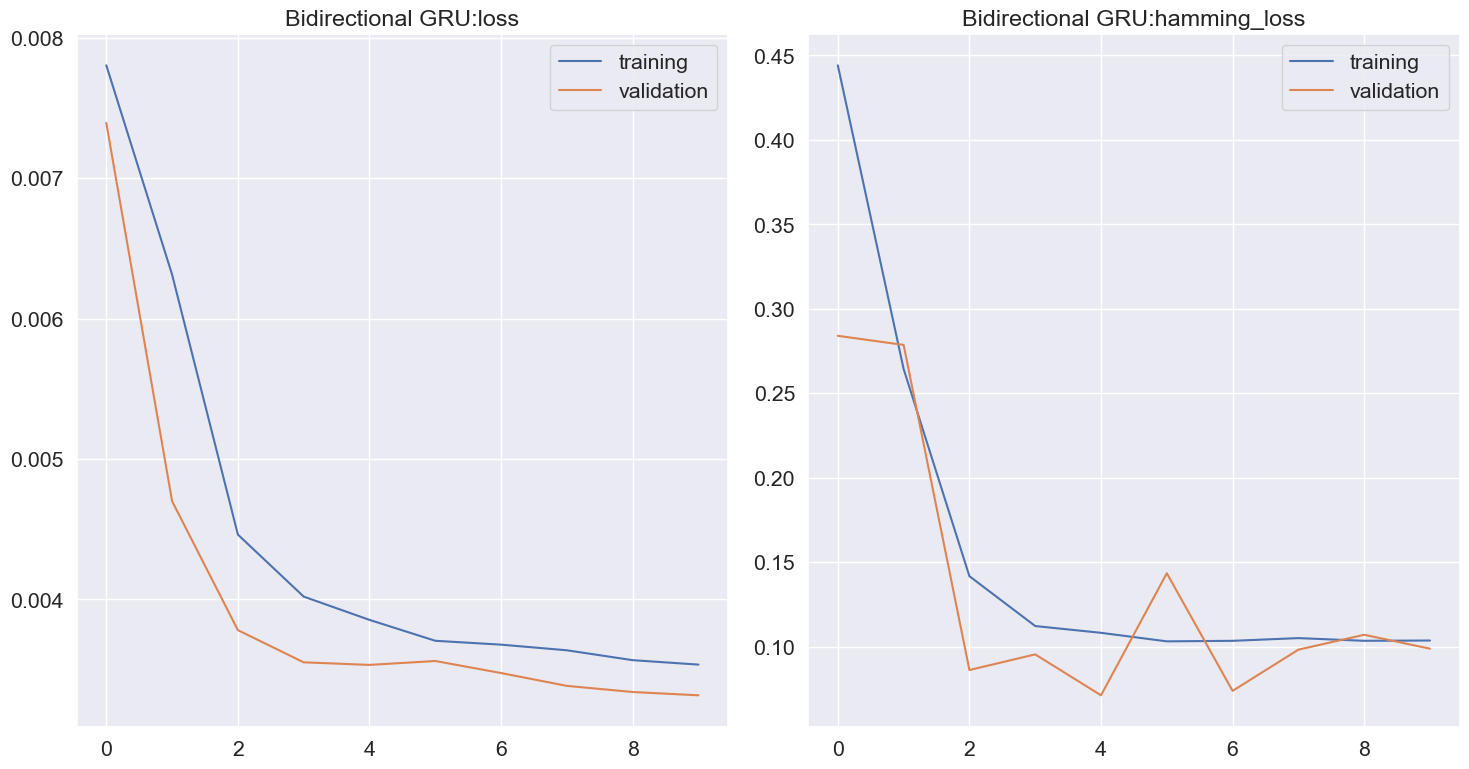

In [46]:
plot_learning_curves(bidir_gru_history, 'Bidirectional GRU')

998/998 [==============================] - 121s 121ms/step


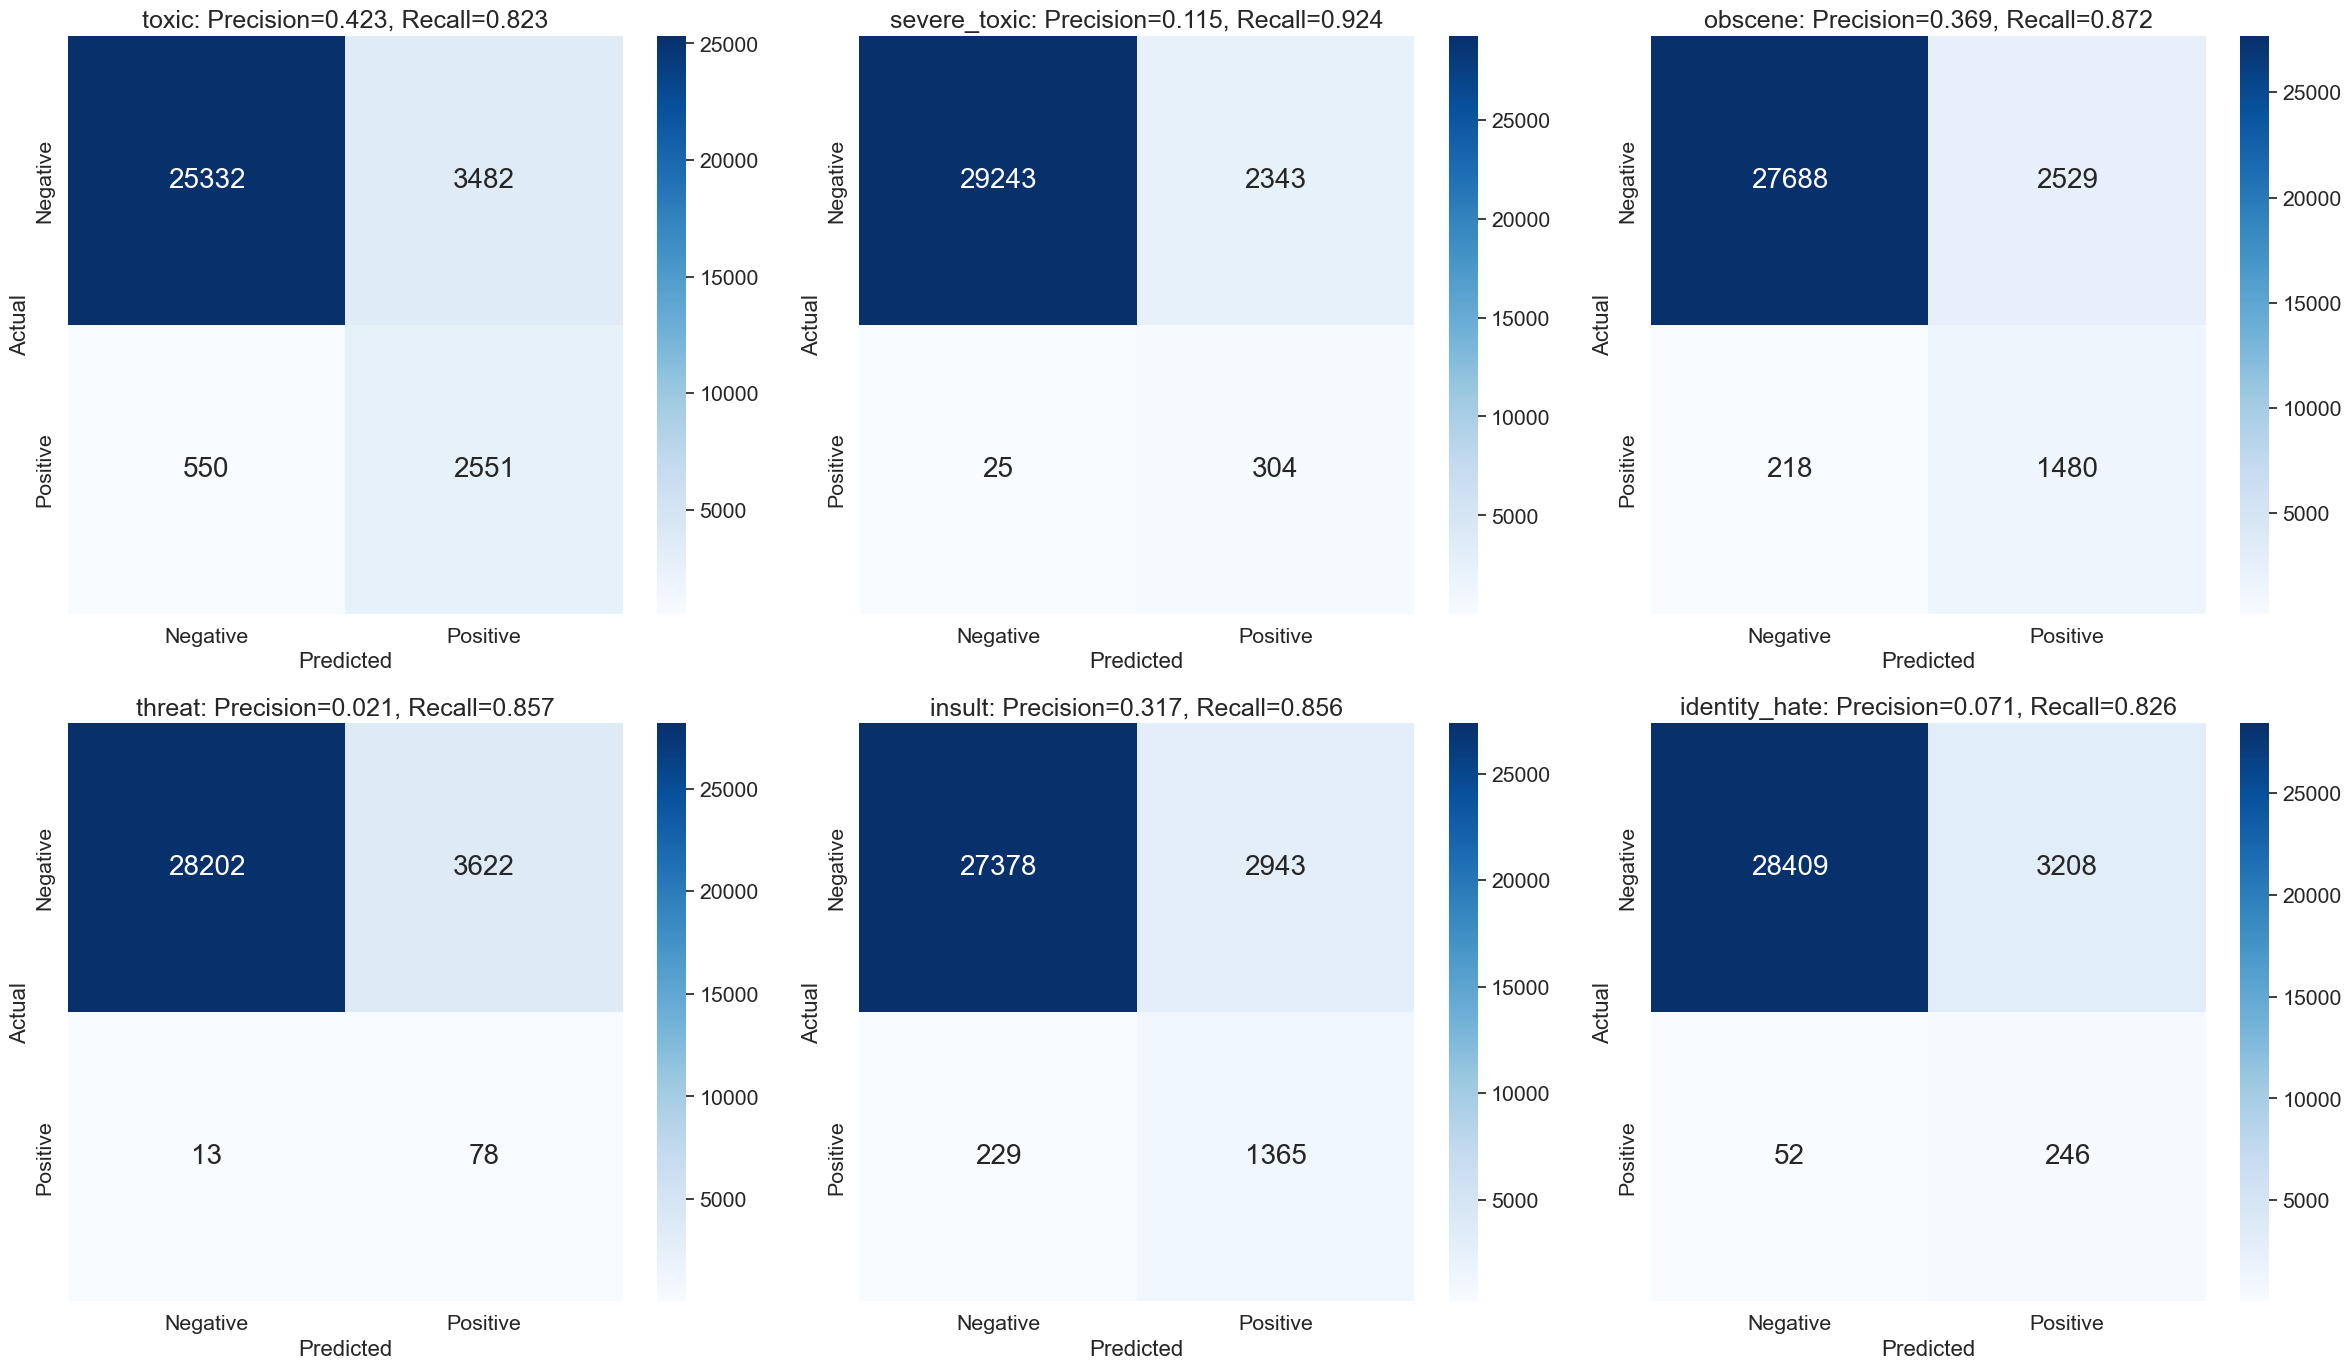

In [47]:
plot_mcms(bidir_gru_model, padded_test_sequences, y_test, labels=labels)

In [117]:
y_pred_proba = bidir_gru_model.predict(padded_test_sequences)

998/998 [==============================] - 118s 118ms/step


In [118]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "bidir_gru_precision": precisions,
    "bidir_gru_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall
0,toxic,0.909,0.517,0.454,0.787,0.565,0.735,0.423,0.823
1,severe_toxic,0.538,0.021,0.119,0.915,0.153,0.881,0.115,0.924
2,obscene,0.874,0.625,0.394,0.866,0.550,0.782,0.369,0.872
3,threat,NaN,0.000,0.019,0.857,0.026,0.681,0.021,0.857
4,insult,0.749,0.495,0.334,0.848,0.411,0.790,0.317,0.856
5,identity_hate,0.800,0.027,0.082,0.836,0.101,0.748,0.071,0.826


Substituting the standard GRU layer with a Bidirectional GRU layer appears to have resulted in a marginal reduction in the architecture's performance. Despite the potential benefits of Bidirectional layers in capturing bidirectional dependencies, it seems that, in this specific context, the improvement is not substantial.

### 2.3 CNN-RNN Hybrid Model

As the model's performance remains unsatisfactory, a decision is made to construct another architecture that better manages the input and output features from the recurrent layer. The new architecture, called `model_CNN_RNN`, incorporates: 
* a Convolutional part to potentially improve the model's ability to capture complex patterns in the data;
* an additional Dense layer following the recurrent layer.

In [48]:
model_CNN_RNN = Sequential([
    Embedding(input_dim=vocab_size,output_dim=128,input_length=maxlen),
    Dropout(0.8),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(64,activation='tanh'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])
model_CNN_RNN.compile(loss=get_weighted_binary_crossentropy(class_weights),
                      optimizer='adam',
                      metrics=[HammingLoss(threshold=0.5, mode='multilabel')])
model_CNN_RNN.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_4 (Embedding)     (None, 1250, 128)         128000    
                                                                 
 dropout_8 (Dropout)         (None, 1250, 128)         0         
                                                                 
 conv1d (Conv1D)             (None, 1250, 64)          24640     
                                                                 
 max_pooling1d (MaxPooling1  (None, 625, 64)           0         
 D)                                                              
                                                                 
 gru_2 (GRU)                 (None, 64)                24960     
                                                                 
 dense_4 (Dense)             (None, 128)               8320      
                                                      

The `Conv1D` layer applies 1D convolution to the embedded sequences. This operation extracts local features and patterns from the input data to detect local dependencies or patterns. It is followed by the `MaxPooling1D` layer, which is employed to reduce the spatial dimensions of the data. It selects the maximum values within a window (pool size of 2), capturing the most significant features and reducing computational complexity. Let's fit this model to the train sequences:

In [49]:
hist_CNN_RNN = model_CNN_RNN.fit(padded_train_sequences, y_train,
                                 validation_data=(padded_val_sequences, y_val),
                                 epochs=10, callbacks=[early_stopping],
                                 batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 680s 453ms/step - loss: 0.0041 - hamming_loss: 0.1525 - val_loss: 0.0033 - val_hamming_loss: 0.1046
Epoch 2/10
1496/1496 [==============================] - 715s 478ms/step - loss: 0.0034 - hamming_loss: 0.1225 - val_loss: 0.0034 - val_hamming_loss: 0.0858
Epoch 3/10
1496/1496 [==============================] - 698s 466ms/step - loss: 0.0032 - hamming_loss: 0.1176 - val_loss: 0.0033 - val_hamming_loss: 0.0969
Epoch 4/10
1496/1496 [==============================] - 709s 474ms/step - loss: 0.0032 - hamming_loss: 0.1165 - val_loss: 0.0035 - val_hamming_loss: 0.0907
Epoch 5/10
1496/1496 [==============================] - 697s 466ms/step - loss: 0.0031 - hamming_loss: 0.1145 - val_loss: 0.0033 - val_hamming_loss: 0.0997
Epoch 6/10
1496/1496 [==============================] - 691s 462ms/step - loss: 0.0031 - hamming_loss: 0.1175 - val_loss: 0.0032 - val_hamming_loss: 0.1071
Epoch 7/10
1496/1496 [==============================] - 692s 463

In [50]:
model_CNN_RNN.save("models/hybrid_model.keras")
pickle.dump(hist_CNN_RNN, open('histories/hybrid_history.pkl','wb'))

In [51]:
hybrid_model = load_model("models/hybrid_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights)})
hybrid_history = pickle.load(open('histories/hybrid_history.pkl','rb'))

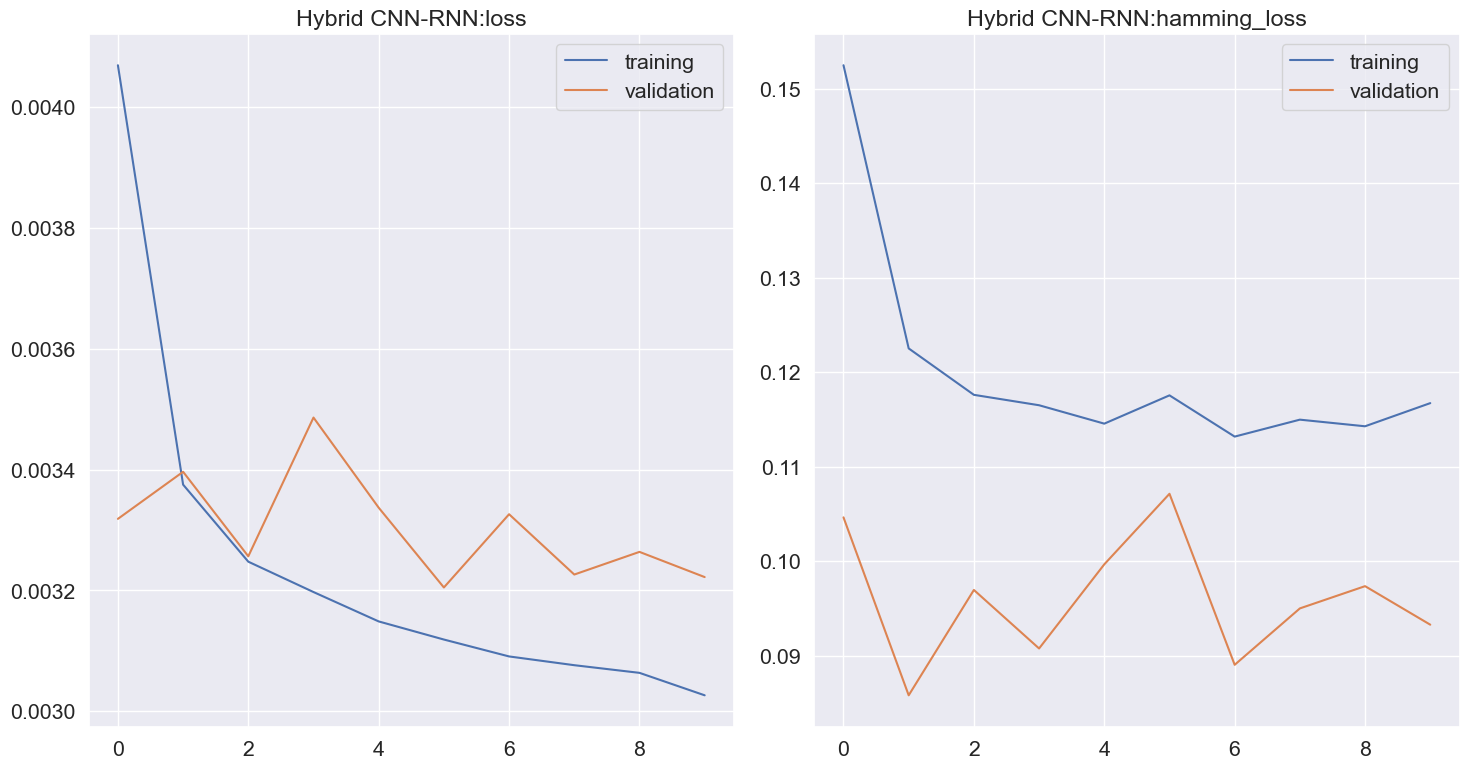

In [52]:
plot_learning_curves(hybrid_history, 'Hybrid CNN-RNN')

998/998 [==============================] - 62s 61ms/step


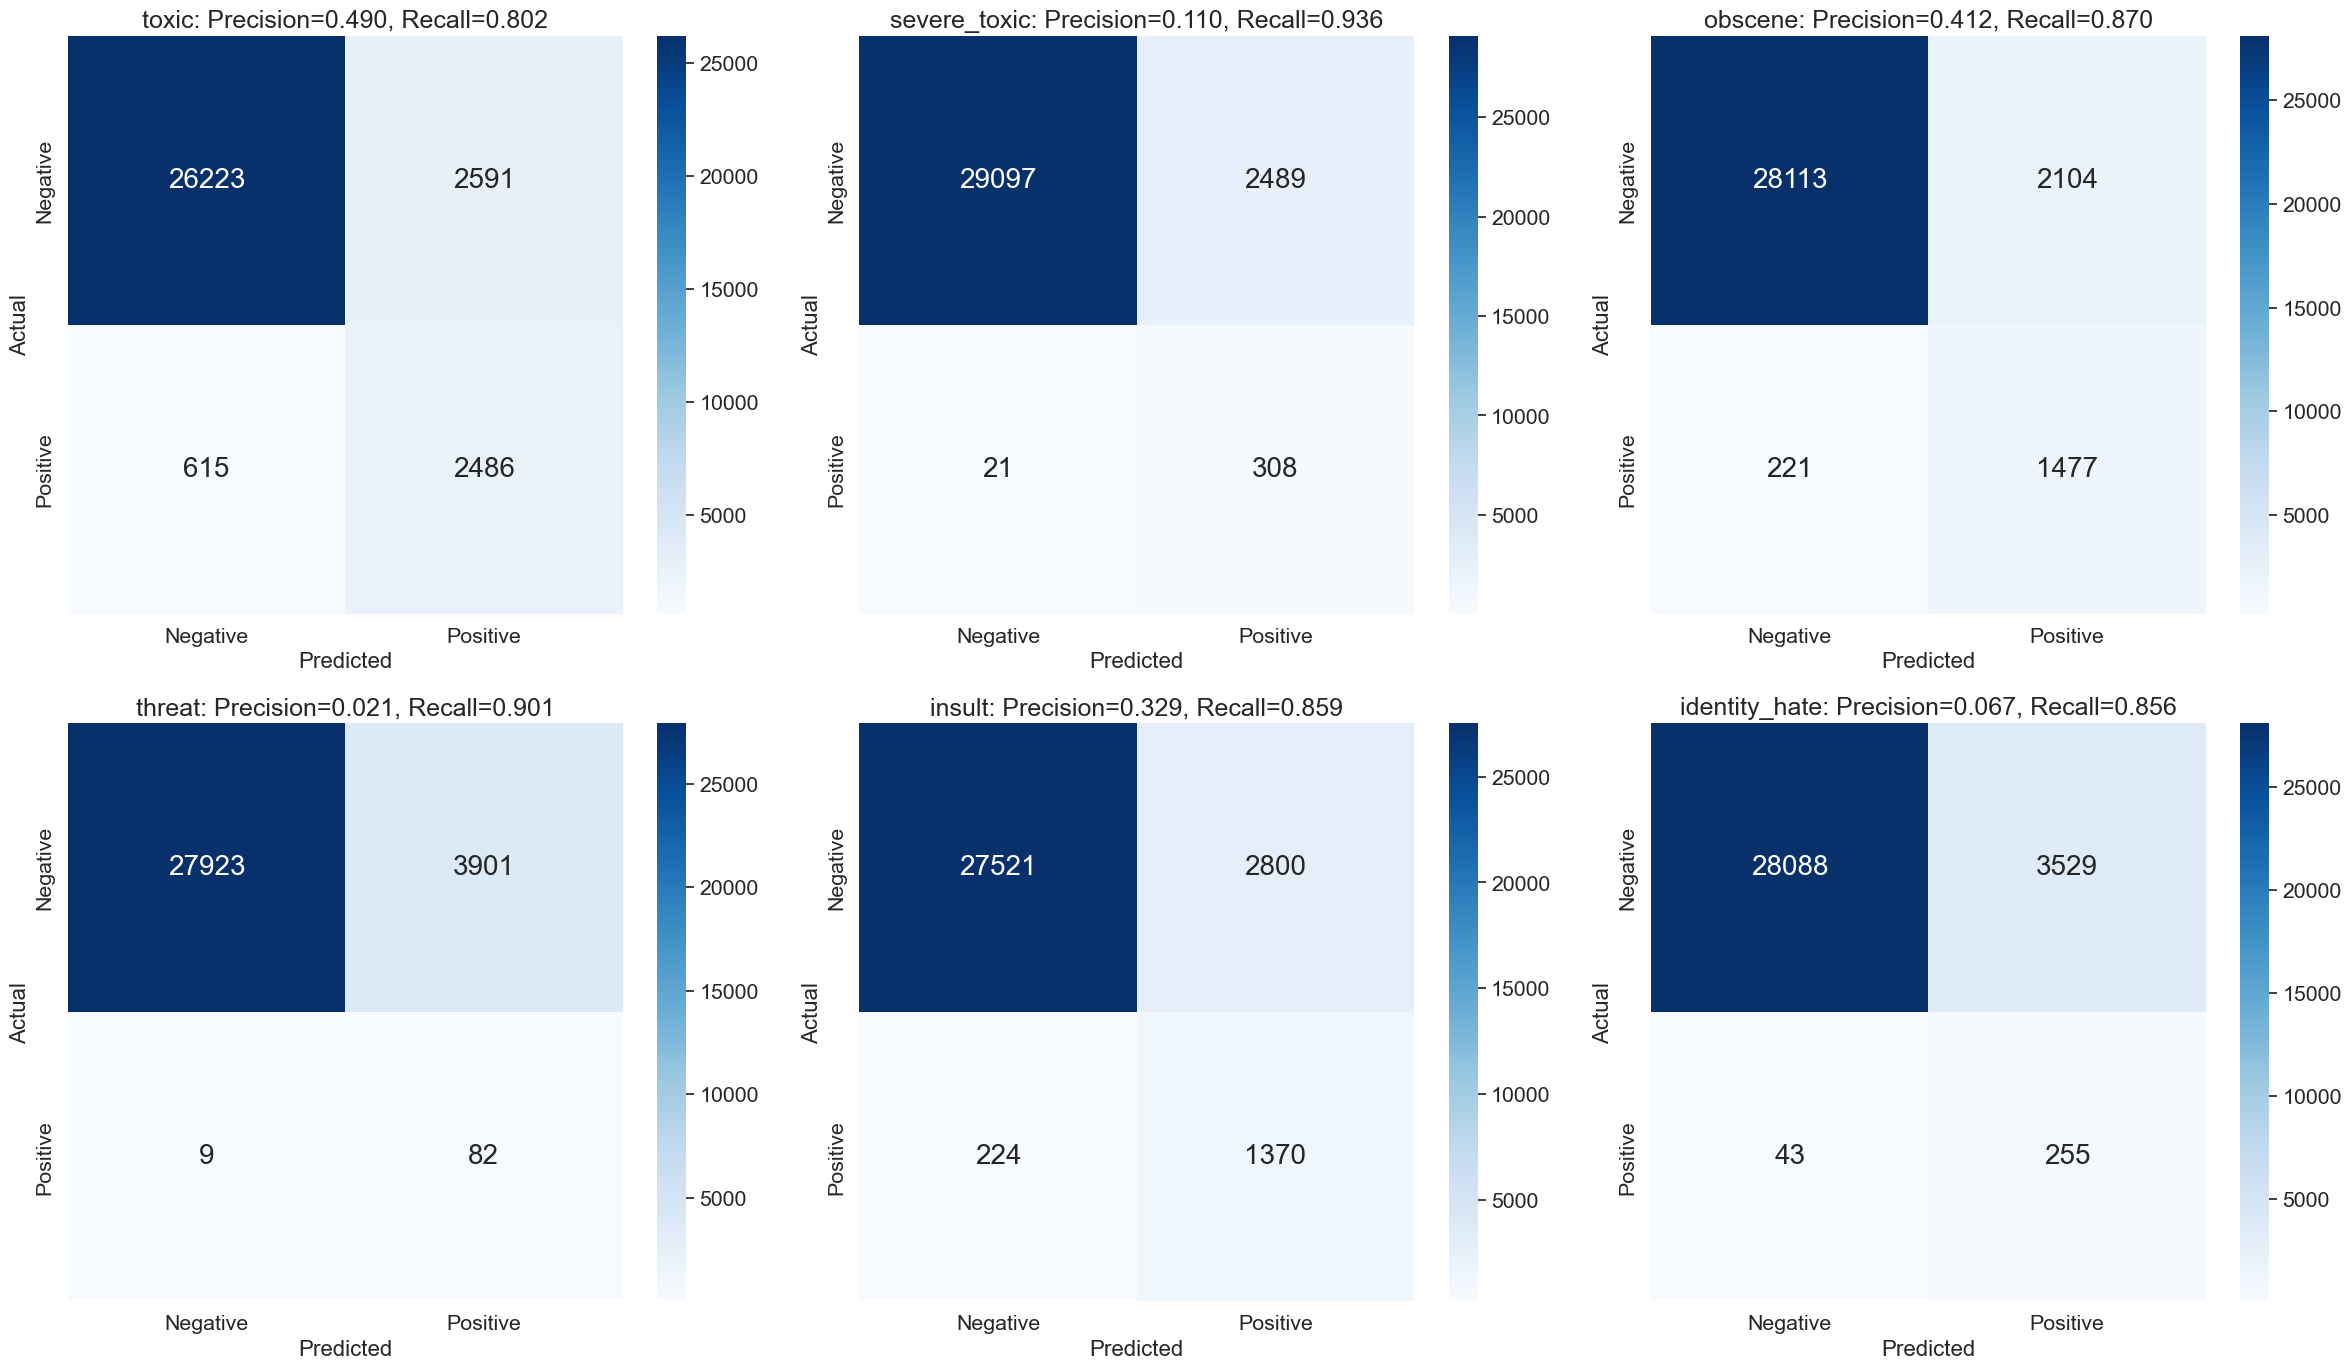

In [53]:
plot_mcms(hybrid_model, padded_test_sequences, y_test, labels=labels)

In [119]:
y_pred_proba = hybrid_model.predict(padded_test_sequences)

998/998 [==============================] - 109s 109ms/step


In [120]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "hybrid_precision": precisions,
    "hybrid_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall,hybrid_precision,hybrid_recall
0,toxic,0.909,0.517,0.454,0.787,0.565,0.735,0.423,0.823,0.490,0.802
1,severe_toxic,0.538,0.021,0.119,0.915,0.153,0.881,0.115,0.924,0.110,0.936
2,obscene,0.874,0.625,0.394,0.866,0.550,0.782,0.369,0.872,0.412,0.870
3,threat,NaN,0.000,0.019,0.857,0.026,0.681,0.021,0.857,0.021,0.901
4,insult,0.749,0.495,0.334,0.848,0.411,0.790,0.317,0.856,0.329,0.859
5,identity_hate,0.800,0.027,0.082,0.836,0.101,0.748,0.071,0.826,0.067,0.856


Although the `val_loss` and `val_hamming_loss` values don't exhibit a significant difference from those of the previous models, this model demonstrates improved precision and recall values for each label. Nevertheless, it's worth noting that the precision values remain relatively low, indicating the presence of a notable number of false positives.

## 2.4 Final Model

As the most recent model has demonstrated superior performance in terms of precision and recall values for each label, it is now a priority to further enhance its capabilities. To achieve this, the following modifications are implemented:
* Increase the `num_words` parameter in the `Tokenizer` from 1000 to 1500.
* Elevate the `output_dim` of the `Embedding` layer from 128 to 256.

These enhancements aim to empower the model by providing it with a more extensive vocabulary and richer feature representations.

In [123]:
padded_train_sequences, padded_val_sequences, padded_test_sequences, vocab_size, maxlen = \
    get_sequences(X_train, X_val, X_test, num_words=1500)

In [124]:
padded_train_sequences.shape, padded_val_sequences.shape, padded_test_sequences.shape

((95742, 1250), (31914, 1250), (31915, 1250))

In [125]:
vocab_size, maxlen

(1500, 1250)

In [95]:
final_model = Sequential([
    Embedding(input_dim=vocab_size,output_dim=256,input_length=maxlen),
    Dropout(0.8),
    Conv1D(filters=64, kernel_size=3, padding='same', activation='relu'),
    MaxPooling1D(pool_size=2),
    GRU(64,activation='tanh'),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(6, activation='sigmoid')
])
final_model.compile(loss=get_weighted_binary_crossentropy(class_weights),
                    optimizer='adam',
                    metrics=[HammingLoss(threshold=0.5, mode='multilabel')])
final_model.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_12 (Embedding)    (None, 1250, 256)         384000    
                                                                 
 dropout_24 (Dropout)        (None, 1250, 256)         0         
                                                                 
 conv1d_8 (Conv1D)           (None, 1250, 64)          49216     
                                                                 
 max_pooling1d_8 (MaxPoolin  (None, 625, 64)           0         
 g1D)                                                            
                                                                 
 gru_10 (GRU)                (None, 64)                24960     
                                                                 
 dense_20 (Dense)            (None, 128)               8320      
                                                     

In [96]:
final_hist = final_model.fit(padded_train_sequences, y_train,
                             validation_data=(padded_val_sequences, y_val),
                             epochs=10, callbacks=[early_stopping],
                             batch_size=64)

Epoch 1/10
1496/1496 [==============================] - 1071s 715ms/step - loss: 0.0037 - hamming_loss: 0.1254 - val_loss: 0.0029 - val_hamming_loss: 0.1014
Epoch 2/10
1496/1496 [==============================] - 1045s 699ms/step - loss: 0.0030 - hamming_loss: 0.1099 - val_loss: 0.0029 - val_hamming_loss: 0.0796
Epoch 3/10
1496/1496 [==============================] - 1026s 686ms/step - loss: 0.0028 - hamming_loss: 0.1091 - val_loss: 0.0030 - val_hamming_loss: 0.0818
Epoch 4/10
1496/1496 [==============================] - 1030s 689ms/step - loss: 0.0027 - hamming_loss: 0.1069 - val_loss: 0.0033 - val_hamming_loss: 0.0905
Epoch 5/10
1496/1496 [==============================] - 1019s 681ms/step - loss: 0.0027 - hamming_loss: 0.1066 - val_loss: 0.0030 - val_hamming_loss: 0.0806
Epoch 6/10
1496/1496 [==============================] - 1023s 684ms/step - loss: 0.0027 - hamming_loss: 0.1044 - val_loss: 0.0030 - val_hamming_loss: 0.0801


In [97]:
final_model.save("models/final_model.keras")
pickle.dump(final_hist, open('histories/final_history.pkl','wb'))

In [98]:
loaded_model = load_model("models/final_model.keras", custom_objects={"weighted_binary_crossentropy": get_weighted_binary_crossentropy(class_weights)})
loaded_history = pickle.load(open('histories/final_history.pkl','rb'))

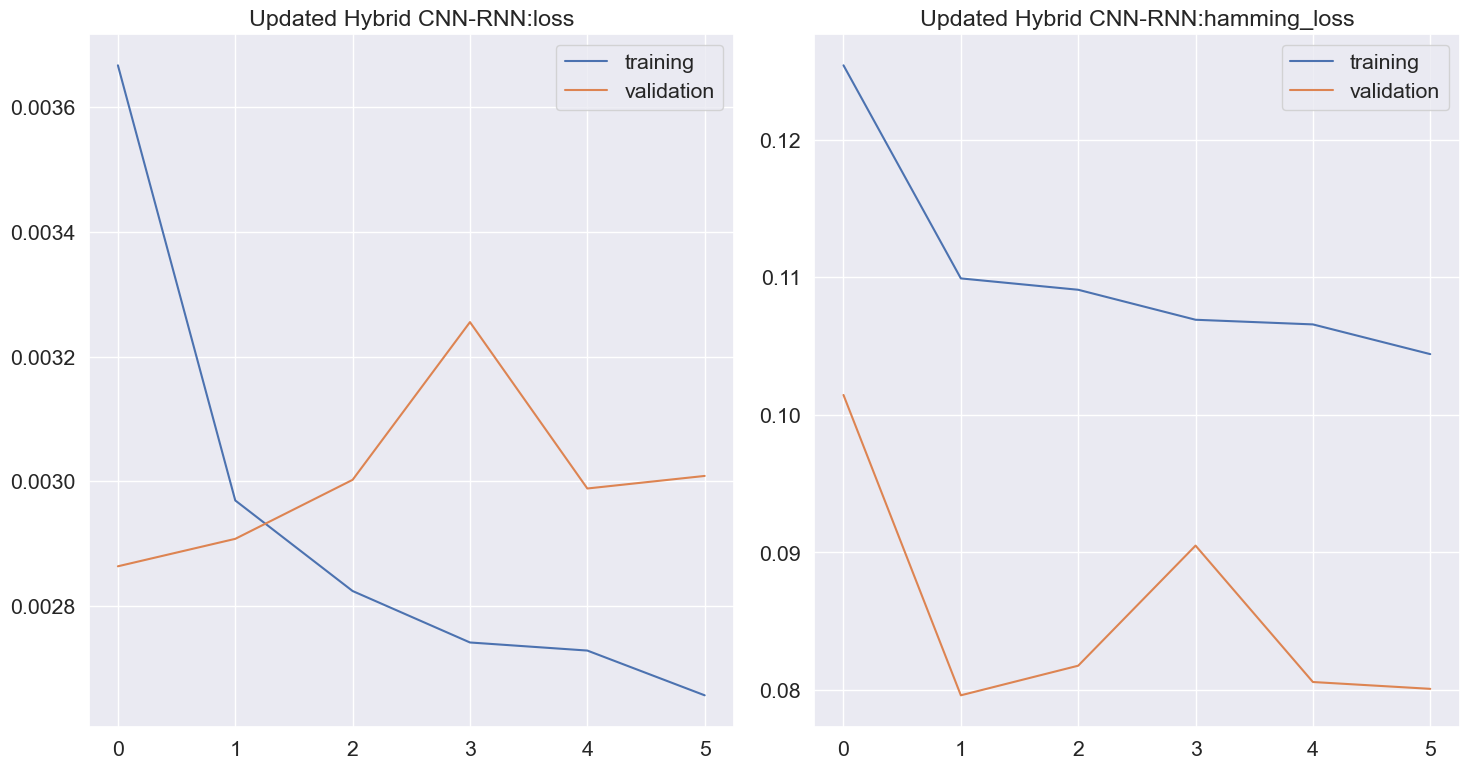

In [99]:
plot_learning_curves(loaded_history, 'Updated Hybrid CNN-RNN')

998/998 [==============================] - 176s 176ms/step


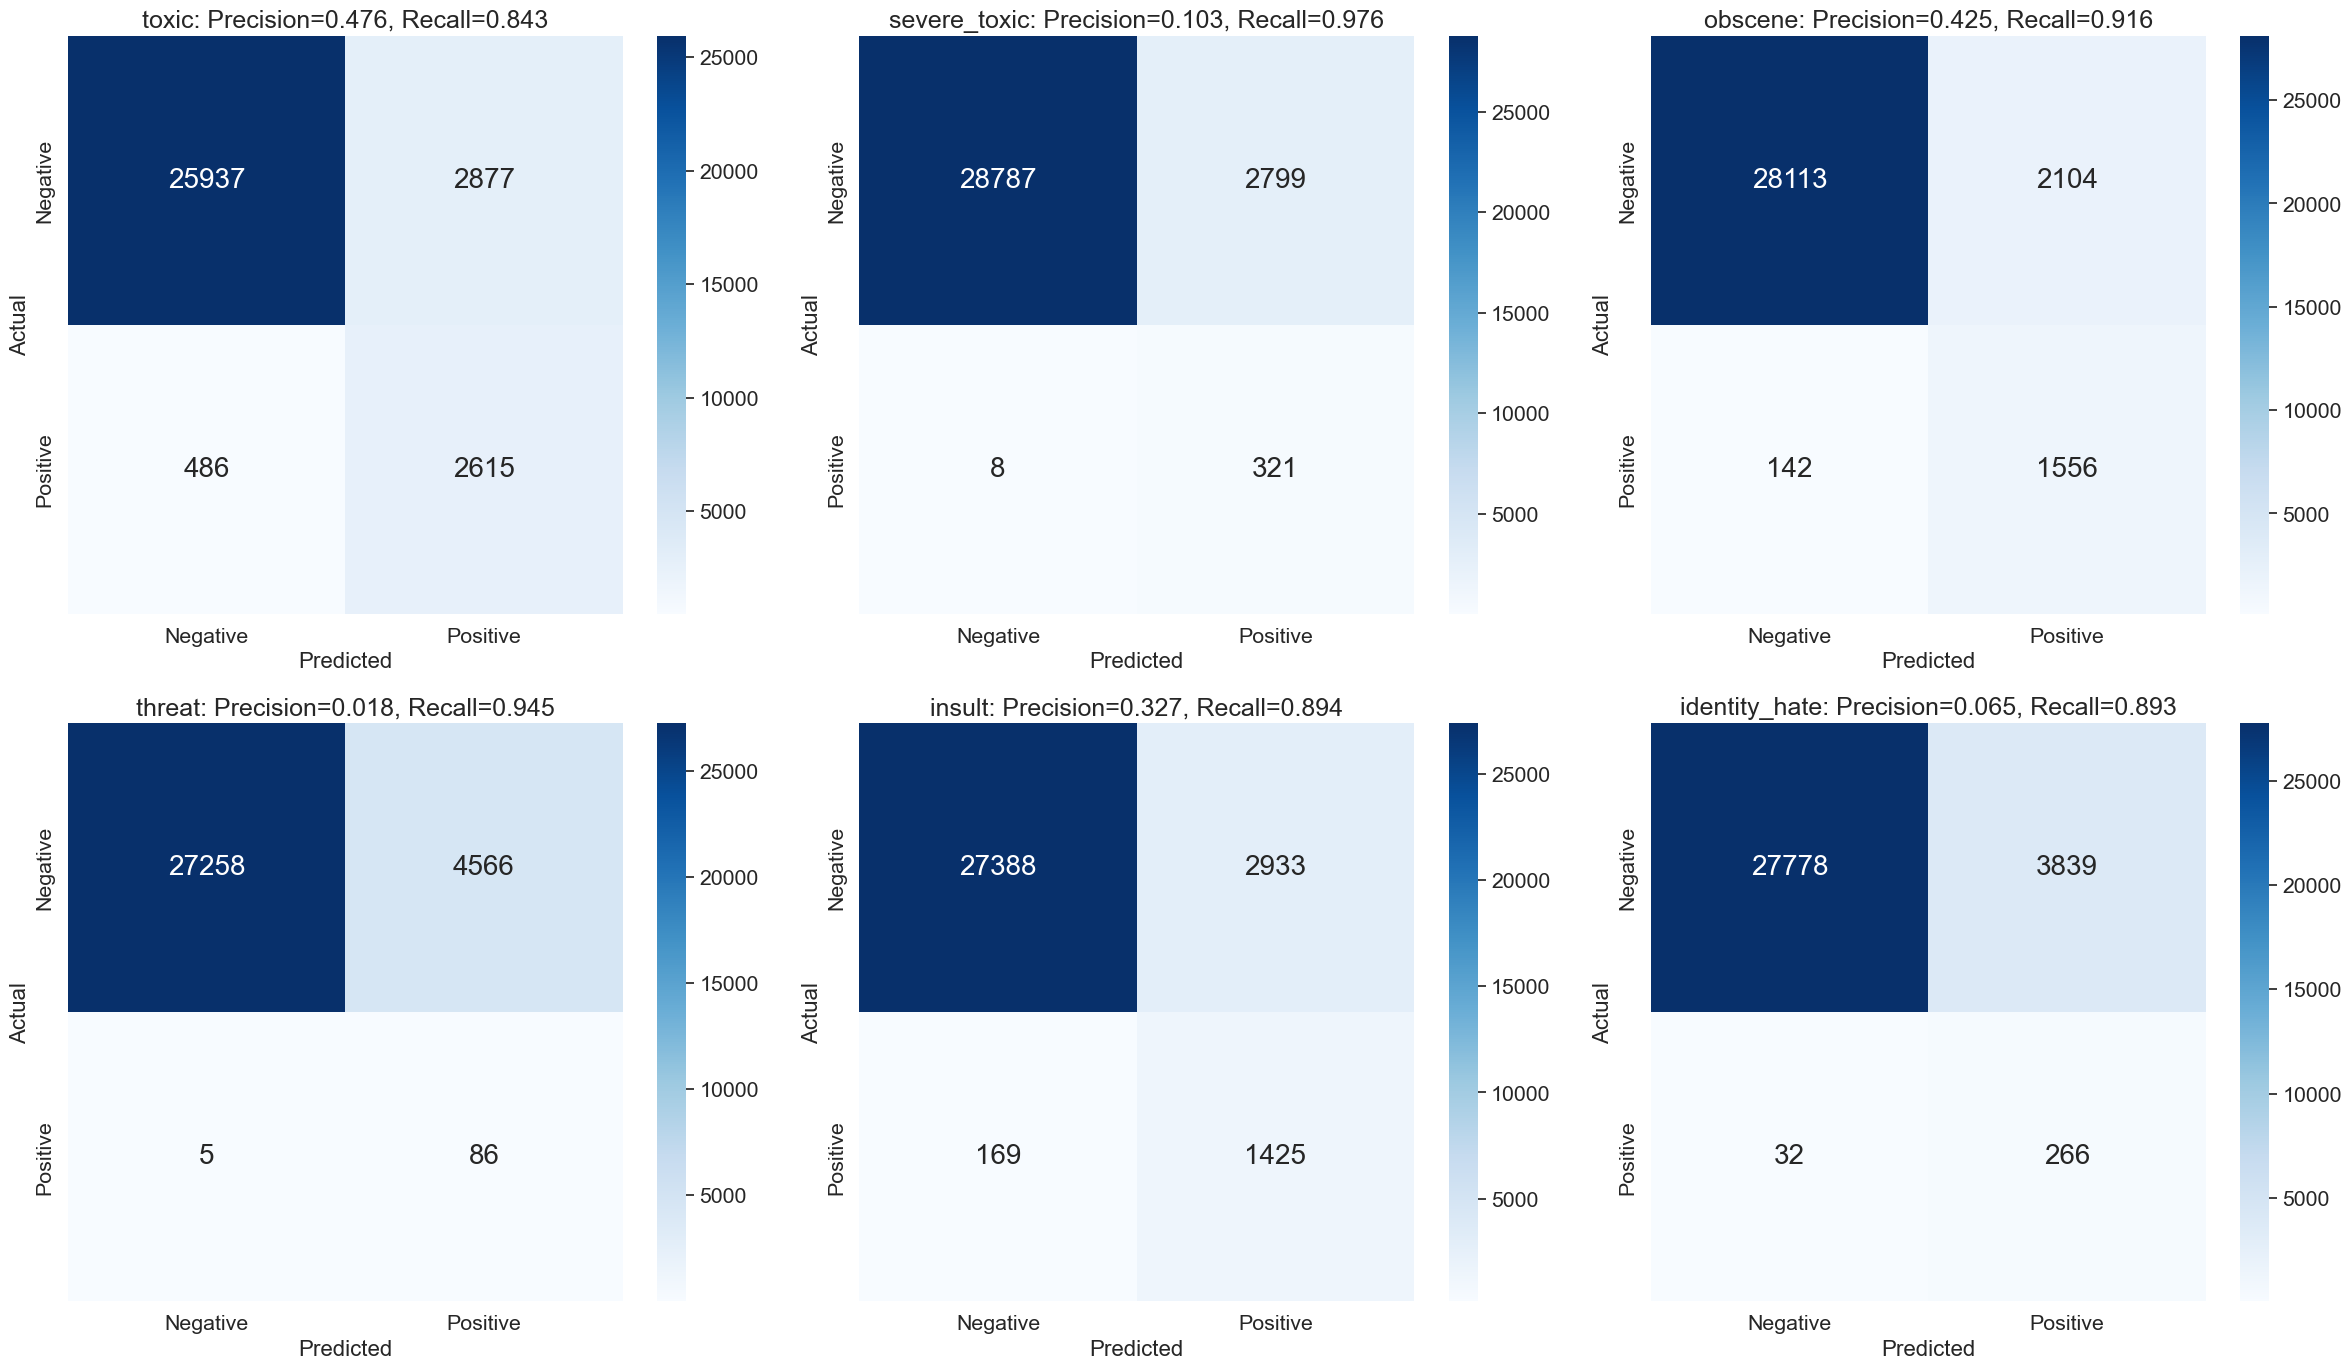

In [100]:
plot_mcms(loaded_model, padded_test_sequences, y_test, labels=labels)

In [126]:
y_pred_proba = loaded_model.predict(padded_test_sequences)

998/998 [==============================] - 121s 121ms/step


In [127]:
y_pred = np.where(y_pred_proba > 0.5, 1, 0)
mcm = multilabel_confusion_matrix(y_test, y_pred)
precisions = []
recalls = []
for i in range(len(labels)):
    tn, fp, fn, tp = mcm[i].ravel()
    precision = round(tp / (tp + fp),3)
    recall = round(tp / (tp + fn),3)
    precisions.append(precision)
    recalls.append(recall)

data = {
    "final_precision": precisions,
    "final_recall": recalls
}

df = df.assign(**data)
df

,Label,rnn_precision,rnn_recall,weighted_rnn_precision,weighted_rnn_recall,gru_precision,gru_recall,bidir_gru_precision,bidir_gru_recall,hybrid_precision,hybrid_recall,final_precision,final_recall
0,toxic,0.909,0.517,0.454,0.787,0.565,0.735,0.423,0.823,0.490,0.802,0.476,0.843
1,severe_toxic,0.538,0.021,0.119,0.915,0.153,0.881,0.115,0.924,0.110,0.936,0.103,0.976
2,obscene,0.874,0.625,0.394,0.866,0.550,0.782,0.369,0.872,0.412,0.870,0.425,0.916
3,threat,NaN,0.000,0.019,0.857,0.026,0.681,0.021,0.857,0.021,0.901,0.018,0.945
4,insult,0.749,0.495,0.334,0.848,0.411,0.790,0.317,0.856,0.329,0.859,0.327,0.894
5,identity_hate,0.800,0.027,0.082,0.836,0.101,0.748,0.071,0.826,0.067,0.856,0.065,0.893


There has been an enhancement in recall values for all labels, while precision values have either remained the same or decreased very slightly.